<a href="https://colab.research.google.com/github/withopenWaigua/ML-NightDay-TsaiTsai/blob/main/Lesson_13_XGBoost_(0229).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 集成学习：XGBoost

In [ ]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
import re, pip, conda
import time
import os

In [ ]:
for package in [sklearn,mlp,np,pd,sns,pip,conda]:
    print(re.findall("([^']*)",str(package))[2],package.__version__)

sklearn 1.0.1
matplotlib 3.4.3
numpy 1.21.4
pandas 1.3.4
seaborn 0.11.2
pip 21.3.1
conda 4.11.0


In [ ]:
#更新pip
#pip install --upgrade pip

#使用pip/conda更新sklearn
#pip install --upgrade scikit-learn
#conda update scikit-learn

目录

**一 XGBoost的基本思想与实现**<br>
&emsp;1 XGBoost pk 梯度提升树<br>
&emsp;2 XGBoost的sklearnAPI实现<br>
&emsp;3 XGBoost的原生库代码实现<br>
&emsp;4 XGBoost分类器的实现<br>
**二 XGBoost的参数**<br>
&emsp;1 迭代过程<br>
&emsp;&emsp; 1.1 迭代次数/学习率/初始$H_0$/最大迭代值<br>
&emsp;&emsp; 1.2 XGBoost的目标函数<br>
&emsp;2 XGBoost中的弱评估器<br>
&emsp;&emsp; 2.1 三大评估器与DART树<br>
&emsp;&emsp; 2.2 XGBoost中弱评估器的分枝<br>
&emsp;&emsp; 2.3 控制复杂度（一）：弱评估器的剪枝<br>
&emsp;&emsp; 2.4 控制复杂度（一）：弱评估器的训练数据<br>
&emsp;3 XGBoost的其他参数与方法<br>
**三 XGBoost中参数空间与自动优化**<br>
&emsp;1 XGBoost的参数空间<br>
&emsp;2 基于TPE对XGBoost进行优化<br>
**四 原理进阶：XGBoost的求解流程**<br>
&emsp;1 XGBoost的基本数学流程<br>
&emsp;2 化简XGBoost的目标函数<br>
&emsp;3 令XGBoost的目标函数最小<br>

推荐的学习路径：

【快速实现XGBoost、跑通代码】- 第一部分<br>
【快速掌握XGBoost应用、达到自由调参水平】- 第一部分~第三部分<br>
【快速掌握XGBoost原理、面试得以通关】- 第一部分1 + 第二部分1.2、2.2 + 第四部分<br>

# 一 XGBoost的基础思想与实现

## 1 XGBoost pk 梯度提升树

极限提升树XGBoost(Extreme Gradient Boosting，XGB，发音/æks-g-boost/)是基于梯度提升树GBDT全面升级的新一代提升算法，也是提升家族中最富盛名、最灵活、最被机器学习竞赛所青睐的算法。不同于我们之前学过的任意单一算法，XGBoost是一个以提升树为核心的算法系统，它覆盖了至少3+建树流程、10+损失函数，可以实现各种类型的梯度提升树，灵活性无与伦比。同时，XGBoost天生被设计成支持巨量数据，因此可以自由接入GPU/分布式/数据库等系统、还创新了众多工程上对传统提升算法进行加速的新方法。可以说，XGBoost是21世纪中Boosting算法的又一个里程碑，它开创了后GBDT时代中Boosting算法的新辉煌。

**<font color="red">需要注意的是，学习XGBoost需要大量梯度提升树（GBDT）相关知识，本课程将假设你已经非常熟悉梯度提升树的原理与特点、并且熟悉sklearn中的交叉验证的用法。如果你不熟悉梯度提升树，强烈建议你回顾之前的课程。</font>**

作为Boosting算法，XGBoost中自然包含Boosting三要素：

- 损失函数$L(y,\hat{y})$ ：用以衡量模型预测结果与真实结果的差异。<br>
- 弱评估器$f(x)$ ：（一般为）决策树，不同的boosting算法使用不同的建树过程。<br>
- 综合集成结果$H(x)$：即集成算法具体如何输出集成结果

并且，XGBoost也遵循Boosting算法的基本流程进行建模：

---
**<font color="green"><center>依据上一个弱评估器$f(x)_{k-1}$的结果，计算损失函数$L$，
    <br>并使用$L$自适应地影响下一个弱评估器$f(x)_k$的构建。<br>集成模型输出的结果，受到整体所有弱评估器$f(x)_0$ ~ $f(x)_K$的影响。</center></font>**
---

当然，XGBoost真实的流程比上述过程复杂得多。虽然梯度提升树的流程本身已经比较复杂，XGBoost还是在此流程上做出了众多关键的改进。综合来看，这些改进都是基于XGBoost中两种非常关键的思想实现的：

- **第一，实现精确性与复杂度之间的平衡**<br>

树的集成模型是机器学习中最为强大的学习器之一，这一族学习器的特点是精确性好、适用于各种场景，但运行缓慢、且过拟合风险很高，因此从学习单一决策树时起，我们就持续为大家提供丰富的剪枝策略，目的就是为了降低各种树模型的模型复杂度，从而控制住过拟合。**树模型的学习能力与过拟合风险之间的平衡，就是预测精确性与模型复杂度之间的平衡，也是经验风险与结构风险之间的平衡**，这一平衡对决策树以及树的集成模型来说是永恒的议题。<br>

在过去，我们总是先建立效果优异的模型，再依赖于手动剪枝来调节树模型的复杂度，但在XGBoost中，精确性与复杂度会在训练的每一步被考虑到。主要体现在：

> - **1. XGBoost为损失函数$L(y,\hat{y})$加入结构风险项，构成目标函数$O(y,\hat{y})$**<br><br>
> 在AdaBoost与GBDT当中，我们的目标是找到损失函数$L(y,\hat{y})$的最小值，也就是让预测结果与真实结果差异最小，这一流程只关心精确性、不关心复杂度和过拟合情况。为应对这个问题，XGBoost从决策树的预剪枝流程、逻辑回归、岭回归、Lasso等经典算法的抗过拟合流程吸取经验，在损失函数中加入了控制过拟合的结构风险项，并将【$L(y,\hat{y})$ + 结构风险】定义为目标函数$O(y,\hat{y})$。<br><br>
> 这一变化让XGBoost在许多方面都与其他Boosting算法不同：例如，XGBoost是向着令目标函数最小化的目标进行训练，而不是令损失函数最小化的方向。再比如，XGBoost会优先利用结构风险中的参数来控制过拟合，而不像其他树的集成模型一样依赖于树结构参数（例如`max_depth`，`min_impurity_decrease`等）。<br><br>
> - **2. 使用全新不纯度衡量指标，将复杂度纳入分枝规则**<br><br>
> 在之前学过的算法当中，无论Boosting流程如何进化，建立单棵决策树的规则基本都遵循我们曾经学过的CART树流程，在分类树中，我们使用信息增益（information gain）来衡量叶子的质量，在回归树中，我们使用MSE或者弗里德曼MSE来衡量叶子的质量。这一流程有成熟的剪枝机制、预测精度高、能够适应各种场景，但却可能建立复杂度很高的树。<br><br>
> 为实现精确性与复杂度之间的平衡，XGBoost重新设定了分枝指标**【结构分数】**（原论文中写作Structure Score，也被称为质量分数Quality Score），以及基于结构分数的**【结构分数增益】**（Gain of structure score），结构分数增益可以逼迫决策树向整体结构更简单的方向生长。<br><br>
> 这一变化让XGBoost使用与传统CART略有区别的建树流程，同时在建树过程中大量使用残差（Residuals）或类残差对象作为中间变量，因此XGBoost的数学过程比其他Boosting算法更复杂。

- **第二，极大程度地降低模型复杂度、提升模型运行效率，将算法武装成更加适合于大数据的算法**<br>

在任意决策树的建树过程中，都需要对每一个特征上所有潜在的分枝节点进行不纯度计算，当数据量巨大时，这一计算将消耗巨量的时间，因此树集成模型的关键缺点之一就是计算缓慢，而这一缺点在实际工业环境当中是相当致命的。为了提升树模型的运算速度、同时又不极大地伤害模型的精确性，XGBoost使用多种优化技巧来实现效率提升：<br>

> - **1. 使用估计贪婪算法、平行学习、分位数草图算法等方法构建了适用于大数据的全新建树流程**<br><br>
> - **2. 使用感知缓存访问技术与核外计算技术，提升算法在硬件上的运算性能**<br><br>
> - **3. 引入Dropout技术，为整体建树流程增加更多随机性、让算法适应更大数据**<br><br>
> 不仅在数学方法上有所改进，XGBoost正式拉开了Boosting算法工程优化的序幕。后续更多的Boosting算法，包括LightGBM，CatBoost等也都是在工程方法上做出了大量的优化。遗憾的是，XGBoost的平行学习、估计贪婪算法等知识点将不会被包括在本次课程当中。在讲解LightGBM的时候，我们将详解基于直方图的估计算法，那时我们就能够很容易地理解XGBoost所使用的估计贪婪算法了。

除此之外，XGBoost还保留了部分与梯度提升树类似的属性，包括：

- **弱评估器的输出类型与集成算法输出类型不一致**

> 对于AdaBoost或随机森林算法来说，当集成算法执行的是回归任务时，弱评估器也是回归器，当集成算法执行分类任务时，弱评估器也是分类器。但对于GBDT以及基于GBDT的复杂Boosting算法们而言，**无论集成算法整体在执行回归/分类/排序任务，弱评估器一定是回归器**。GBDT通过sigmoid或softmax函数输出具体的分类结果，但实际弱评估器一定是回归器，XGBoost也是如此。

- **拟合负梯度，且当损失函数是0.5倍MSE时，拟合残差**

> 任意Boosting算法都有自适应调整弱评估器的步骤。在GBDT当中，每次用于建立弱评估器的是样本$X$以及当下集成输出$H(x_i)$与真实标签$y$之间的伪残差（也就是负梯度）。当损失函数是$\frac{1}{2}MSE$时，负梯度在数学上等同于残差（Residual），因此**GBDT是通过拟合残差来影响后续弱评估器结构**。XGBoost也是依赖于拟合残差来影响后续弱评估器结构，但是与GBDT一样，这一点需要通过数学来证明。

- **抽样思想**

> GBDT借鉴了大量Bagging算法中的抽样思想，XGBoost也继承了这一属性，因此在XGBoost当中，我们也可以对样本和特征进行抽样来增大弱评估器之间的独立性

因为存在这些相似之处，因此我们将会在XGBoost的参数中看到部分熟悉的参数，如果你对梯度提升树足够熟悉，那XGBoost的许多参数对你来说应该并不难懂。需要注意的是，作为2014年才被正式提出的Boosting算法，XGBoost是一个独立于经典算法的算法系统，因此xgboost库是需要单独安装的。

你可以使用以下代码在cmd中非常简单地安装xgboost，通常来说无需配置环境变量。

In [ ]:
#!pip install xgboost #安装xgboost库
#!pip install --upgrade xgboost #更新xgboost库

In [ ]:
import xgboost as xgb #导入成功则说明安装正确

In [ ]:
xgb.__version__

'1.5.1'

需要注意的是，windows与linux系统下支持单GPU运算，但Mac系统不支持GPU运算。同时，只有Linux系统支持多GPU联合运算，其他系统不支持。如果pip安装失败，则可以删除后参考该页面进行具体安装：https://xgboost.readthedocs.io/en/stable/install.html

## 2 XGBoost回归的sklearnAPI实现

不同于内嵌在sklearn框架中的其他算法，xgboost是独立的算法库，因此它有一套不同于sklearn代码的原生代码。大部分时候我们使用原生代码来运行xgboost，因为这套原生代码是完全为集成学习所设计的，不仅可以无缝使用交叉验证、默认输出指标为RMSE，还能够默认输出训练集上的结果帮我们监控模型。然而对于熟悉sklearn的我们来说，这一套代码略有难度，因此许多人也会倾向于使用xgboost自带的sklearn接口来实现算法。

XGBoost自带sklearn接口（sklearn API），通过这个接口，我们可以使用跟sklearn代码一样的方式来实现xgboost，即可以通过fit和predict等接口来执行训练预测过程，也可以调用属性比如coef_等。在XGBoost的sklearn API中，我们可以看到下面五个类：

|类|说明|
|:-:|:-:|
|**XGBRegressor()**|实现xgboost回归|
|**XGBClassifier()**|实现xgboost分类|
|**XGBRanker()**|实现xgboost排序|
|**XGBRFClassifier()**|基于xgboost库实现随机森林分类|
|**XGBRFRegressor()**|基于xgboost库实现随机森林回归|

其中XGBRF的两个类是以XGBoost方式建树、但以bagging方式构建森林的类，通常只有在我们使用普通随机森林效果不佳、但又不希望使用Boosting的时候使用。这种使用XGBoost方式建树的森林在sklearn中已经开始了实验，不过还没有正式上线。

另外两个类就很容易理解了，一个是XGBoost的回归，一个是XGBoost的分类。这两个类的参数高度相似，我们可以以XGBoost回归为例查看：

*class* `xgboost.XGBRegressor`(n_estimators, max_depth, learning_rate, verbosity, objective, booster, tree_method, n_jobs, gamma, min_child_weight, max_delta_step, subsample, colsample_bytree, colsample_bylevel, colsample_bynode, reg_alpha, reg_lambda, scale_pos_weight, base_score, random_state, missing, num_parallel_tree, monotone_constraints, interaction_constraints, importance_type, gpu_id, validate_parameters, predictor, enable_categorical, eval_metric, early_stopping_rounds, callbacks,**kwargs)

*class* `xgboost.XGBClassifier`(n_estimators, use_label_encoder, max_depth, learning_rate, verbosity, objective, booster, tree_method, n_jobs, gamma, min_child_weight, max_delta_step, subsample, colsample_bytree, colsample_bylevel, colsample_bynode, reg_alpha, reg_lambda, scale_pos_weight, base_score, random_state, missing, num_parallel_tree, monotone_constraints, interaction_constraints, importance_type, gpu_id, validate_parameters, predictor, enable_categorical, **kwargs)

可以看到，两个类的参数两都很多，其中不乏一些我们非常熟悉的参数，例如`n_estimators`，`learning_rate`, `max_depth`等。但大部分参数还是需要我们重新学习和认识，这与xgboost复杂的原理有很大的关系，但由于是sklearn API，所以所有这些参数都有相应的默认值。我们可以在不认识参数的情况下调用这个类。以回归类为例我们来看：

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate, KFold
from sklearn.model_selection import train_test_split

In [ ]:
data = pd.read_csv(r"D:\Pythonwork\2021ML\PART 2 Ensembles\datasets\House Price\train_encode.csv",index_col=0)

In [ ]:
data.head()

,Id,住宅类型,住宅区域,街道接触面积(英尺),住宅面积,街道路面状况,巷子路面状况,住宅形状(大概),住宅现状,水电气,...,泳池面积,泳池质量,篱笆质量,其他配置,其他配置的价值,销售月份,销售年份,销售类型,销售状态,SalePrice
0,0.0,5.0,3.0,36.0,327.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2.0,8.0,4.0,208500
1,1.0,0.0,3.0,51.0,498.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,1.0,8.0,4.0,181500
2,2.0,5.0,3.0,39.0,702.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8.0,2.0,8.0,4.0,223500
3,3.0,6.0,3.0,31.0,489.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,0.0,140000
4,4.0,5.0,3.0,55.0,925.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,2.0,8.0,4.0,250000


In [ ]:
#回归数据
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [ ]:
X.shape

(1460, 80)

In [ ]:
y.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

在这个数据集上我们曾经达到过如下的分数：

|算法|RF|AdaBoost|GBDT|RF<br>(TPE)|AdaBoost<br>(TPE)|GBDT<br>(TPE)|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|5折验证<br>运行时间|1.29s|0.28s|0.49s|0.22s|0.27s|<font color="brown">**1.54s(↑)**</font>|
|测试最优分数<br>(RMSE)|30571.267|35345.931|28783.954|28346.673|35169.730|<font color="green">**26415.835(↓)**</font>|

In [ ]:
#sklearn普通训练代码三步走：实例化，fit，score

Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,y,test_size=0.3,random_state=1412)

xgb_sk = XGBRegressor(random_state=1412) #实例化模型
xgb_sk.fit(Xtrain,Ytrain)
xgb_sk.score(Xtest,Ytest) #默认指标R2

0.8707175563742298

In [ ]:
#sklearn交叉验证三步走：实例化，交叉验证，对结果求平均

xgb_sk = XGBRegressor(random_state=1412) #实例化模型

In [ ]:
#定义所需的交叉验证方式
cv = KFold(n_splits=5,shuffle=True,random_state=1412)

result_xgb_sk = cross_validate(xgb_sk,X,y,cv=cv
                               ,scoring="neg_root_mean_squared_error" #负根均方误差
                               ,return_train_score=True
                               ,verbose=True
                               ,n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


In [ ]:
result_xgb_sk

{'fit_time': array([0.23205304, 0.45810175, 0.46110272, 0.47810745, 0.47210622]),
 'score_time': array([0.00499988, 0.00500083, 0.00700212, 0.00600123, 0.0080018 ]),
 'test_score': array([-25398.06063039, -42892.11176772, -26426.91326917, -20676.41934632,
        -33375.56869975]),
 'train_score': array([ -903.74997856, -1106.45801425,  -997.3799282 ,  -818.69215194,
         -877.57892862])}

In [ ]:
def RMSE(result,name):
    return abs(result[name].mean())

In [ ]:
RMSE(result_xgb_sk,"train_score")

940.7718003131752

In [ ]:
RMSE(result_xgb_sk,"test_score")

29753.814742669765

可以看到，在默认参数下，xgboost模型极度不稳定，并且过拟合的情况非常严重，在训练集上的RMSE达到了前所未有的低点940.77，这说明XGBoost的学习能力的确强劲，现有数据量对xgboost来说可能有点不足。在没有调整任何参数的情况下，XGBoost的表现没能胜过梯度提升树，这可能是因为在默认参数下梯度提升树的过拟合程度较轻。我们可以尝试使用之前学过的知识，对XGBoost的参数略微进行调整，例如将最可能影响模型的参数之一：`max_depth`设置为一个较小的值。

In [ ]:
xgb_sk = XGBRegressor(max_depth=5,random_state=1412) #实例化

In [ ]:
result_xgb_sk = cross_validate(xgb_sk,X,y,cv=cv
                               ,scoring="neg_root_mean_squared_error" #负根均方误差
                               ,return_train_score=True
                               ,verbose=True
                               ,n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


In [ ]:
RMSE(result_xgb_sk,"train_score")

2362.6596931022264

In [ ]:
RMSE(result_xgb_sk,"test_score")

28623.2199609373

过拟合程度立刻减轻了，这说明模型是有潜力的，经过精密的调参之后xgboost上应该能够获得不错的结果。

当sklearn API训练完毕之后，我们可以调用sklearn中常见的部分属性对训练后的模型进行查看，例如查看特征重要性的属性`feature_importances_`，以及查看XGB下每一棵树的`get_booster()`方法、查看总共有多少棵树的`get_num_boosting_rounds()`方法、以及查看当前所有参数的方法`get_params`。

In [ ]:
xgb_sk = XGBRegressor(max_depth=5,random_state=1412).fit(X,y)

In [ ]:
#查看特征重要性
xgb_sk.feature_importances_

array([2.75380560e-04, 3.31971998e-04, 1.00358156e-02, 1.05883693e-03,
       3.16664134e-03, 0.00000000e+00, 1.98506648e-04, 2.89293937e-03,
       1.25273280e-02, 0.00000000e+00, 5.93377743e-04, 1.02778999e-02,
       2.30982271e-03, 1.63636741e-03, 2.90878420e-03, 2.35304120e-03,
       6.21278654e-04, 4.83804524e-01, 3.57081974e-03, 5.26868505e-03,
       5.39273489e-03, 1.19193934e-03, 6.73988950e-04, 8.58596177e-04,
       7.24220707e-04, 6.31435658e-04, 6.40772341e-04, 1.79228242e-02,
       1.88877675e-04, 5.03550633e-04, 1.56989340e-02, 2.03612563e-03,
       2.47432292e-03, 1.01661379e-03, 8.10322072e-03, 2.90135911e-04,
       5.88890282e-04, 7.41500990e-04, 1.55724427e-02, 4.79830429e-04,
       3.00964224e-04, 3.08048874e-02, 1.71841952e-04, 1.05094137e-02,
       7.64262909e-03, 5.08715457e-04, 3.02572548e-02, 2.92710634e-03,
       3.74272262e-04, 3.38621549e-02, 1.68845232e-03, 5.42165304e-04,
       3.92313190e-02, 2.88939234e-02, 3.41931777e-03, 3.12080747e-03,
      

In [ ]:
#调出其中一棵树，不过无法展示出树的细节，只能够调出建树的Booster对象
xgb_sk.get_booster()[2]

一棵树都是一个单独的Booster提升树，Booster就相当于sklearn中DecisionTreeRegressor，只不过是使用xgboost独有的建树规则进行计算。

In [ ]:
#查看一共建立了多少棵树，相当于是n_estimators的取值
xgb_sk.get_num_boosting_rounds()

100

In [ ]:
#获取每一个参数的取值
xgb_sk.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'enable_categorical': False,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 16,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 1412,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

查看参数对xgboost来说很有意义，因为XGBRegressor的说明中没有注明默认参数，因此通过查看参数，我们可以了解到xgboost在sklearn API中都设置了怎样的参数，作为未来调参的参考。对于xgboost分类器，我们还可以调用`predict_proba`这样的方法来输出概率值，除此之外我们一般不会再用到xgboost sklearn API中的其他功能。

## 3 XGBoost回归的原生代码实现

XGBoost的原生代码与我们已经习惯了的sklearn代码有很大的不同。首先，**原生代码必须使用XGBoost自定义的数据结构DMatrix**，这一数据结构能够保证xgboost算法运行更快，并且能够自然迁移到GPU上运行，类似于列表、数组、Dataframe等结构都不能用于原生代码，因此使用原生代码的第一步就是要更换数据结构。

![](http://pictes.oss-cn-beijing.aliyuncs.com/%E5%BE%AE%E8%AF%BE%20-%20sklearn/week%2011%20XGBoost/xgb%E5%BB%BA%E6%A8%A1%E6%B5%81%E7%A8%8B.PNG)

当设置好数据结构后，**我们需要以字典形式设置参数**。XGBoost也可以接受像sklearn一样，将所有参数都写在训练所用的类当中，然而由于xgboost的参数列表过长、参数类型过多，直接将所有参数混写在训练模型的类中会显得代码冗长且混乱，因此我们往往会使用字典单独呈现参数。准备好参数列表后，**我们将使用xgboost中自带的方法`xgb.train`或`xgb.cv`进行训练**，训练完毕后，我们可以使用`predict`方法对结果进行预测。虽然xgboost原生代码库所使用的数据结构是DMatrix，但在预测试输出的数据结构却是普通的数组，因此可以直接使用sklearn中的评估指标，或者python编写的评估指标进行评估。接下来，我们来认识一下xgboost原生代码中最关键的方法：

*class* `xgboost.DMatrix`(data, label=None, *, weight=None, base_margin=None, missing=None, silent=False, feature_names=None, feature_types=None, nthread=None, group=None, qid=None, label_lower_bound=None, label_upper_bound=None, feature_weights=None, enable_categorical=False)

*function* `xgboost.train`(*params, dtrain, num_boost_round=10, *, evals=None, obj=None, feval=None, maximize=None, early_stopping_rounds=None, evals_result=None, verbose_eval=True, xgb_model=None, callbacks=None, custom_metric=None)

*function* `xgboost.cv`(*params, dtrain, num_boost_round=10, nfold=3, stratified=False, folds=None, metrics=(), obj=None, feval=None, maximize=None, early_stopping_rounds=None, fpreproc=None, as_pandas=True, verbose_eval=None, show_stdv=True, seed=0, callbacks=None, shuffle=True, custom_metric=None)

其中，方法`xgb.train`和`xgb.cv`的第一个参数`params`就是我们需要使用字典自定义的参数列表，第二个参数`dtrain`就是DMatrix结构的训练数据，第三个参数`num_boost_round`其实就等同于sklearn中的`n_estimators`，表示总共建立多少棵提升树，也就是提升过程中的迭代次数。

在之后的课程中，我们将会详细讲解训练中涉及到的每一个参数，在这里我们了解前三个参数就可以。和sklearn中一样，xgboost中的这些参数也都拥有默认值，因此我们可以不填写任何参数就运行xgboost算法。现在，我们来简单看看原生代码是如何实现的：

In [ ]:
import xgboost as xgb

- 将数据转换为DMatrix

XGBoost模块的三步走：将数据转换为DMatrix，定义需要输入的参数params，直接调用训练。第一步，先转换数据格式：

In [ ]:
X.head() #DataFrame

,Id,住宅类型,住宅区域,街道接触面积(英尺),住宅面积,街道路面状况,巷子路面状况,住宅形状(大概),住宅现状,水电气,...,半开放式门廊面积,泳池面积,泳池质量,篱笆质量,其他配置,其他配置的价值,销售月份,销售年份,销售类型,销售状态
0,0.0,5.0,3.0,36.0,327.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,8.0,4.0
1,1.0,0.0,3.0,51.0,498.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,8.0,4.0
2,2.0,5.0,3.0,39.0,702.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2.0,8.0,4.0
3,3.0,6.0,3.0,31.0,489.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,0.0
4,4.0,5.0,3.0,55.0,925.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11.0,2.0,8.0,4.0


In [ ]:
data_xgb = xgb.DMatrix(X,y)

In [ ]:
data_xgb

In [ ]:
type(data_xgb)

xgboost.core.DMatrix

如上所示，DMatrix会将特征矩阵与标签打包在同一个对象中，且一次只能转换一组数据。并且，我们无法通过索引或循环查看内部的内容，一旦数据被转换为DMatrix，就难以调用或修改了：

In [ ]:
data_xgb[0]

TypeError: 'DMatrix' object is not subscriptable

In [ ]:
for i in data_xgb:
    print(i)
    break

TypeError: 'DMatrix' object is not iterable

因此，**数据预处理需要在转换为DMatrix之前做好**。如果我们有划分训练集和测试集，则需要分别将训练集和测试集转换为DMatrix：

In [ ]:
#如果有分割训练集和测试集
from sklearn.model_selection import train_test_split
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,y,test_size=0.3,random_state=1412)

In [ ]:
dtrain = xgb.DMatrix(Xtrain,Ytrain)
dtest = xgb.DMatrix(Xtest,Ytest)

- 定义所需要输出的参数，直接进行训练

In [ ]:
params = {"max_depth":5,"seed":1412}

一般来说params中会包含至少7~10个参数，如果我们在大型数据上使用xgboost，则可能会涉及到十几个参数或以上，这些参数大多与sklearn中呈现不同的名称，我们将在后续课程中逐一讲解，现在我们可以写上两个我们非常熟悉的参数：最大深度`max_depth`以及随机数种子`seed`。

In [ ]:
reg = xgb.train(params, data_xgb, num_boost_round=100)

不难发现，**XGBoost不需要实例化，`xgb.train`函数包揽了实例化和训练的功能**，一行代码解决所有问题。同时，**XGBoost在训练时没有区分回归和分类器，它默认是执行回归算法**，因此当我们执行回归任务时，代码是最为简单的。

在这行简单的代码中，比较令人困惑的可能是参数`num_boost_round`的位置。作为控制树的数量的参数，它的性质应该与控制树深度的`max_depth`差不多，因此一般来说，我们会倾向于将与模型学习过程相关的参数应该都在params中设置。然而，如果我们将`num_boost_round`写在params当中，则会出现如下警告：

In [ ]:
params = {"num_boost_round":100,"max_depth":5,"seed":1412}
reg = xgb.train(params, data_xgb)

[18:27:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




这个警告说明，xgboost不推荐将参数`num_boost_round`写在params里，即便现在这样可以运行，但在之后的版本迭代中也会逐渐舍弃这个功能。这既是说，xgboost将参数分为了两大部分，一部分可以通过params进行设置，另一部分则需要在方法`xgb.train`或者`xgb.cv`中进行设置。遗憾的是，xgboost并没有明确对参数分割的条件和理由，但一般来说，**除了建树棵树、提前停止这两个关键元素，其他参数基本都被设置在params当中**。如果在实际运行过程中，出现了警告或报错，则根据实际情况进行调整。

在运行完`xgb.train`后，我们就已经训练完毕后，训练到的reg可以直接用于预测：

In [ ]:
y_pred = reg.predict(data_xgb)

In [ ]:
y_pred

array([187948.77 , 154381.31 , 199905.75 , ..., 249179.   , 124129.945,
       145862.28 ], dtype=float32)

我们可以使用sklearn中的评估指标进行评估，对回归类算法，xgboost的默认评估指标是RMSE

In [ ]:
from sklearn.metrics import mean_squared_error as MSE
MSE(y,y_pred,squared=False) #RMSE

16853.386170715003

- 使用交叉验证进行训练

In [ ]:
params = {"max_depth":5,"seed":1412}
result = xgb.cv(params,data_xgb,num_boost_round=100
                ,nfold=5 #补充交叉验证中所需的参数，nfold=5表示5折交叉验证
                ,seed=1412 #交叉验证的随机数种子，params中的是管理boosting过程的随机数种子
               )

In [ ]:
result

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,141522.721875,1318.896997,141941.484375,6432.947712
1,102183.568750,1053.673671,103857.753125,5778.064364
2,74524.579688,728.019143,77554.021875,5732.164228
3,55214.231250,465.428776,59894.982031,6121.923227
4,41754.467188,345.496649,47824.114063,5734.477932
...,...,...,...,...
95,2513.421875,206.432972,28623.110938,7513.194129
96,2476.676709,201.605999,28624.677344,7517.551419
97,2440.533399,203.698024,28620.468359,7523.209246
98,2405.017529,210.983203,28619.228125,7525.503699


如上所示，result返回了一个100行，4列的矩阵，格式为DataFrame。

该矩阵行数与迭代次数一致，当我们规定迭代次数为100时，这个矩阵就有100行，如果我们规定的迭代次数为10，这个矩阵就只会有10行。每一行代表了每次迭代后进行交叉验证的结果的均值，例如索引为0的行就表示迭代了一次时（刚建立第一棵树时），进行5折交叉验证的结果，最后一行的结果也就是当前模型迭代完毕后（建好了全部的`nun_boost_round`棵树时）输出的结果，也是之前我们使用sklearn API时得到过的结果：测试集上5折交叉验证结果28623.22。

每次迭代后xgboost会执行5折交叉验证，并收集交叉验证上的训练集RMSE均值、训练集RMSE的标准差、测试集RMSE的均值、测试集RMSE的标准差，这些数据构成了4列数据。实际上，这个矩阵展示了每次迭代过后，进行5折交叉验证的结果，也展示出了随着迭代次数增多，模型表现变化的趋势，因此输出结果可以被用于绘制图像。

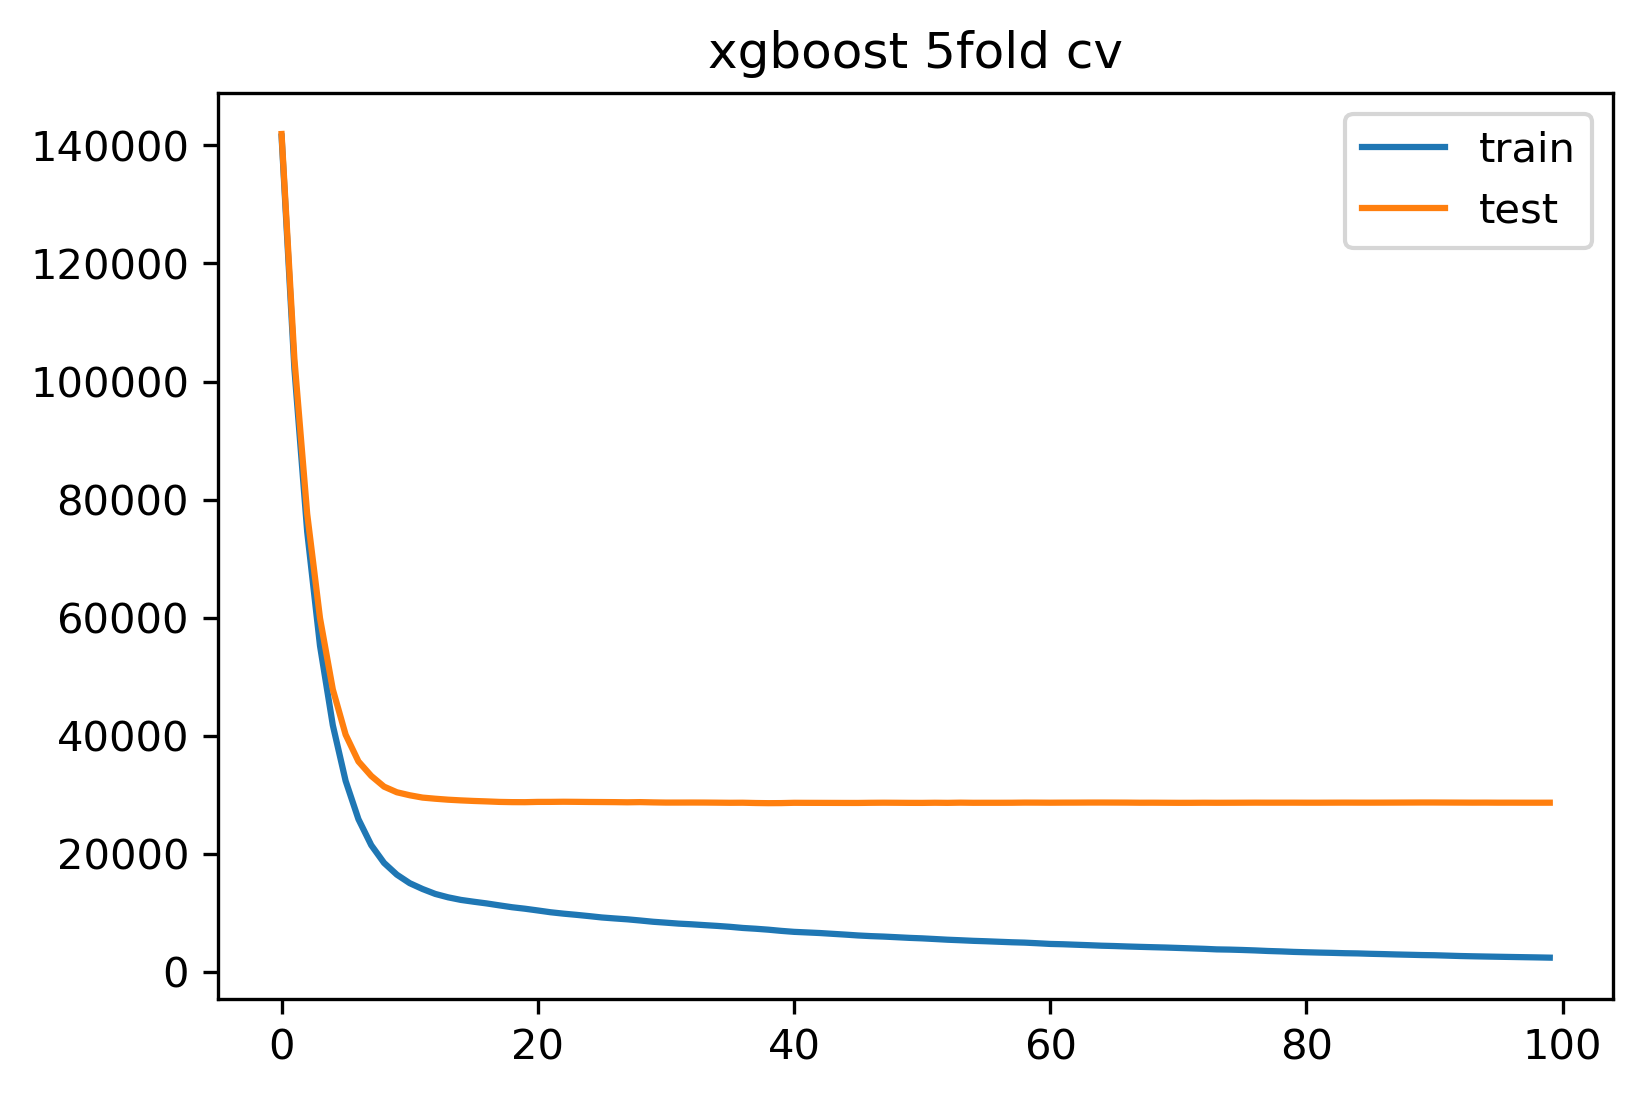

In [ ]:
plt.figure(dpi=300)
plt.plot(result["train-rmse-mean"])
plt.plot(result["test-rmse-mean"])
plt.legend(["train","test"])
plt.title("xgboost 5fold cv");

## 4 XGBoost分类的代码实现

XGBoost默认会实现回归算法，因此在执行分类的时候，我们需要主动声明算法的类型。xgboost是通过当前算法所使用的损失函数来判断任务类型的，即是通过在params中填写的`objective`参数来判断任务类型。当不再执行回归任务时，模型的评估指标也会发生变化，因此xgboost分类所需要的参数会更多。`objective`参数中可以输入数十种不同的选项，常见的有：

- 用于回归
> - **reg:squarederror**：平方损失，即$\frac{1}{2}(y - \hat{y})^2$，其中1/2是为了计算简便<br><br>
> - **reg:squaredlogerror**：平方对数损失，即$\frac{1}{2}[log(\hat{y} + 1) - log(y + 1)]^2$，其中1/2是为了计算简便

- 用于分类
> - **binary:logistic**：二分类交叉熵损失，使用该损失时`predict`接口输出概率。如果你对该损失不熟悉，你需要学习逻辑回归算法。<br><br>
> - **binary:logitraw**：二分类交叉熵损失，使用该损失时`predict`接输出执行sigmoid变化之前的值<br><br>
> - **multi:softmax**：多分类交叉熵损失，使用该损失时`predict`接口输出具体的类别。如果你对该损失不熟悉，你需要学习AdaBoost与GBDT。<br><br>
> - **multi:softprob**：多分类交叉熵，适用该损失时`predict`接口输出每个样本每个类别下的概率

除此之外，还有众多用于排序算法、计数算法的损失函数。xgboost几乎适用于所有可微的损失函数，不同的损失函数会影响`predict`的输出，但却不会影响交叉验证方法`xgb.cv`的输出。当不填写任何内容时，参数`objective`的默认值为`reg:squarederror`。接下来我们来看看xgboost分类器的实现：

- 导入数据

In [ ]:
#导入2个最简单的分类数据集：乳腺癌数据集与手写数字数据集
from sklearn.datasets import load_breast_cancer, load_digits

#二分类数据
X_binary = load_breast_cancer().data
y_binary = load_breast_cancer().target
data_binary = xgb.DMatrix(X_binary,y_binary)

#多分类数据
X_multi = load_digits().data
y_multi = load_digits().target
data_multi = xgb.DMatrix(X_multi, y_multi)

- 设置params，进行训练

相比起默认的回归算法，xgboost分类算法所需的参数会更多一些。二分类损失函数一般需要搭配参数`eval_matric`，用于设置分类的评估指标。xgboost中默认的二分类指标是对数损失（也就是交叉熵损失`logloss`），在更老的版本中，xgboost中默认的二分类指标是错误率`error`，在某些xgboost版本当中，不设置参数`eval_matric`将引发警告。

In [ ]:
params1 = {"seed":1412, "objective":"binary:logistic"
           ,"eval_metric":"logloss" #二分类交叉熵损失
          }
clf_binary = xgb.train(params1, data_binary, num_boost_round=100)

对多分类算法来说，除了设置损失函数和评估指标，还需要设置参数`num_class`。参数`num_class`用于多分类状况下、具体的标签类别数量，例如，如果是三分类，则需设置{"num_calss":3}。通常来说，算法应该能够根据标签的情况自主判断实际类别为多少，但不知为何，在xgboost原生代码及sklearn API当中，部分版本的xgboost都存在无法判断标签类别数量的问题。为避免报错，建议在执行多分类时写上该参数。

In [ ]:
params2 = {"seed":1412, "objective":"multi:softmax"
           ,"eval_metric":"mlogloss" #多分类交叉熵损失 #"merror"
           ,"num_class":10}
clf_multi = xgb.train(params2, data_multi, num_boost_round=100)

- 预测与评估

In [ ]:
y_pred_binary = clf_binary.predict(data_binary)
y_pred_multi = clf_multi.predict(data_multi)

In [ ]:
y_pred_binary[:20] #二分类直接返回概率，不返回类别，需要自己转换

array([5.8410629e-03, 5.9211289e-04, 1.5155278e-04, 2.4505438e-02,
       8.6602634e-03, 2.3524903e-02, 8.7698136e-05, 2.2055734e-04,
       1.5081177e-03, 4.2824438e-03, 1.5698196e-02, 2.2565569e-04,
       4.6376034e-04, 9.0418644e-03, 7.7753547e-03, 6.4944592e-04,
       9.2663817e-05, 1.2998856e-04, 9.4483788e-05, 9.9722409e-01],
      dtype=float32)

In [ ]:
y_pred_multi #多分类，选择`multi:softmax`时返回具体类别，也可以选择`multi:softprob`返回概率。

array([0., 1., 2., ..., 8., 9., 8.], dtype=float32)

In [ ]:
from sklearn.metrics import accuracy_score as ACC #当返回具体类别时，可以使用准确率
from sklearn.metrics import log_loss as logloss #当返回概率时，则必须使用交叉熵损失

In [ ]:
(y_pred_binary > 0.5).astype("int")

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

In [ ]:
ACC(y_binary,(y_pred_binary > 0.5).astype(int)) #对二分类计算准确率，则必须先转换为类别

1.0

In [ ]:
ACC(y_multi, y_pred_multi)

1.0

两个数据都非常简单，对于xgboost来说都学习到了100%的准确率。来看交叉熵损失：

In [ ]:
logloss(y_binary,y_pred_binary) #只有二分类输出了概率，因此可以查看交叉熵损失

0.004539324697500797

- 交叉验证

分类算法与回归算法执行交叉验证的流程基本一致，但需要注意的是，当使用`xgb.train`时，我们会将评估指标参数`eval_matric`写在params中，在使用`xgb.cv`时，我们却需要将评估指标参数写在`xgb.cv`当中，否则有时候会报出警告。这是一个奇怪的bug，可能会随着xgboost库的迭代更新而消失。如果不介意警告，可以继续将评估指标写在params里的`eval_matric`参数下。在`xgb.cv`当中，我们需要将评估指标打包成元组，写在参数`metrics`内部，如下所示：

In [ ]:
params2 = {"seed":1412
           , "objective":"multi:softmax" #无论填写什么损失函数都不影响交叉验证的评估指标
           , "num_class":10}
result = xgb.cv(params2,data_multi,num_boost_round=100
                ,metrics = ("mlogloss") #交叉验证的评估指标由cv中的参数metrics决定
                ,nfold=5 #补充交叉验证中所需的参数，nfold=5表示5折交叉验证
                ,seed=1412 #交叉验证的随机数种子，params中的是管理boosting过程的随机数种子
               )

In [ ]:
result #返回多分类交叉熵损失

,train-mlogloss-mean,train-mlogloss-std,test-mlogloss-mean,test-mlogloss-std
0,1.228912,0.006192,1.330349,0.039377
1,0.869281,0.005974,1.009304,0.046665
2,0.642709,0.005521,0.805701,0.050207
3,0.484223,0.004590,0.658486,0.049434
4,0.370331,0.004205,0.552657,0.049002
...,...,...,...,...
95,0.003921,0.000027,0.118105,0.027968
96,0.003908,0.000026,0.118007,0.027899
97,0.003896,0.000026,0.118073,0.027942
98,0.003885,0.000026,0.117976,0.027911


参数`metrics`支持多个评估指标：

In [ ]:
params3 = {"seed":1412
           , "objective":"multi:softmax" #无论填写什么损失函数都不影响交叉验证的评估指标
           , "num_class":10}
result = xgb.cv(params3,data_multi,num_boost_round=100
                ,metrics = ("mlogloss","merror")
                ,nfold=5 #补充交叉验证中所需的参数，nfold=5表示5折交叉验证
                ,seed=1412 #交叉验证的随机数种子，params中的是管理boosting过程的随机数种子
               )

In [ ]:
result #可以执行多个指标，让输出结果的列数翻倍

,train-mlogloss-mean,train-mlogloss-std,train-merror-mean,train-merror-std,test-mlogloss-mean,test-mlogloss-std,test-merror-mean,test-merror-std
0,1.228912,0.006192,0.030746,0.002658,1.330349,0.039377,0.122978,0.022670
1,0.869281,0.005974,0.014329,0.003948,1.009304,0.046665,0.094041,0.022593
2,0.642709,0.005521,0.008765,0.002732,0.805701,0.050207,0.080682,0.022009
3,0.484223,0.004590,0.005147,0.001432,0.658486,0.049434,0.070664,0.022264
4,0.370331,0.004205,0.003200,0.001362,0.552657,0.049002,0.065101,0.018976
...,...,...,...,...,...,...,...,...
95,0.003921,0.000027,0.000000,0.000000,0.118105,0.027968,0.038392,0.005910
96,0.003908,0.000026,0.000000,0.000000,0.118007,0.027899,0.038392,0.005910
97,0.003896,0.000026,0.000000,0.000000,0.118073,0.027942,0.038392,0.005910
98,0.003885,0.000026,0.000000,0.000000,0.117976,0.027911,0.038392,0.005910


- sklearn API的实现

In [ ]:
from xgboost import XGBClassifier

由于在sklearn API当中，我们明确了正在执行的任务是分类，因此无需再使用损失函数来帮助我们辨别分类的类型了。然而如果是多分类，建议还是在参数中明确所使用的损失函数：

In [ ]:
clf = XGBClassifier()

In [ ]:
clf.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'enable_categorical': False,
 'gamma': None,
 'gpu_id': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [ ]:
clf = XGBClassifier(objective="multi:softmax"
                    , eval_metric="mlogloss" #设置评估指标避免警告
                    , num_class = 10
                  #  , use_label_encoder=False
                   ) 

In [ ]:
clf = clf.fit(X_multi,y_multi)

In [ ]:
clf.predict(X_multi) #输出具体数值 - 具体的预测类别

array([0, 1, 2, ..., 8, 9, 8])

In [ ]:
clf.predict_proba(X_multi).shape #输出概率值

(1797, 10)

In [ ]:
clf.score(X_multi,y_multi) #虽然设置了评估指标，但score接口还是准确率

1.0

到这里，你已经基本掌握了xgboost建模的代码。如果你没有提升模型的需求，只需要跑通代码结果，那这部分内容就足够你使用了。从下一部分开始，我们将详细讲解xgboost中涉及到的所有重要参数。

# 二 XGBoost的参数

在之前的课程当中，我们已经认识了几个xgboost的参数，包括设置迭代次数的`num_boost_round`，设置损失函数的`objective`，设置评估指标的`eval_matric`，以及设置多分类类别数的`num_class`。这些参数有些是在params中设置的参数，有些是需要在方法`.train`或者`.cv`中设置的参数，但这些参数只是xgboost参数的九牛一毛。由于xgboost本身是一个复杂的算法系统，其超参数的数量十分惊人，我已经将可能用到的参数总结在了如下表格当中，其中标注为绿色的是我们未曾学过、或必须讲解的重要参数。

|类型|参数|
|-|-|
|**迭代过程/目标函数**|**params**: eta, base_score, objective, <font color="green">**lambda, gamma, alpha, max_delta_step**</font><br>**xgb.train()**: num_boost_round|
|**弱评估器结构**|**params**: max_depth, <font color="green">**booster, min_child_weight**</font>|
|**dart树**|**params**: <font color="green">**sample_type, normalized_type, rate_drop, one_drop, skip_drop**</font>|
|**弱评估器的训练数据**|**params**: subsample, <font color="green">**sampling_method, colsamle_bytree, colsample_bylevel, colsample_bynode**</font>|
|**提前停止**|**xgb.train()**: <font color="green">**early_stopping_rounds, evals**</font>, eval_metric|
|**其他**|**params**: seed, <font color="green">**verbosity, scale_pos_weight, nthread**</font>|

需要的时，在实现xgboost的两种方式中（原生代码与sklearn API），参数的名称可能不同。**在后续课程当中，我将会持续使用原生代码进行讲解，并附上该参数在sklearn API下的名称**。有的参数可能只能在原生代码中使用，如果出现该情况，则会特殊标注出来。在后续案例课程当中，我们将会大量使用xgboost的原生代码，强烈建议以xgboost原生代码为核心进行学习，如果你考虑继续使用sklearn API，可以参考之前课程中所有适用于sklearn的代码，大部分代码都适用。

## 1 迭代过程

### 1.1 迭代次数/学习率/初始$H_0$/最大迭代值

作为Boosting算法，XGBoost的迭代流程与GBDT高度相似，因此XGBoost自然而然也有设置具体迭代次数的参数`num_boost_round`、学习率参数`eta`以及设置初始迭代值的`base_score`。

具体地来说，对于样本$x_i$，集成算法当中一共有$K$棵树，则参数`num_boost_round`的取值为K。假设现在正在建立第$k$个弱评估器，则第$k$个弱评估器上$x_i$的结果可以表示为$f_k(x_i)$。假设整个Boosting算法对样本$x_i$输出的结果为$H(x_i)$，则该结果一般可以被表示为k=1~k=K过程当中，所有弱评估器结果的加权求和：

$$H(x_i) =  \sum_{k=1}^\boldsymbol{\color{red}K}\phi_kf_k(x_i)$$

其中，$\phi_k$为第k棵树的权重。特别的，XGBoost算法不计算树权重，因此XGBoost的输出结果为：

$$H(x_i) =  \sum_{k=1}^\boldsymbol{\color{red}K}f_k(x_i)$$

对于第$k$次迭代来说，则有：

$$H_k(x_i) = H_{k-1}(x_i) + f_k(x_i)$$

在这个一般过程中，每次将本轮建好的决策树加入之前的建树结果时，可以增加参数$\color{red}\eta$，表示为第k棵树加入整体集成算法时的学习率，对标参数`eta`。

$$H_k(x_i) = H_{k-1}(x_i) + \boldsymbol{\color{red}\eta} f_k(x_i)$$

该学习率参数控制Boosting集成过程中$H(x_i)$的增长速度，是相当关键的参数。当学习率很大时，$H(x_i)$增长得更快，我们所需的`num_boost_round`更少，当学习率较小时，$H(x_i)$增长较慢，我们所需的`num_boost_round`就更多，因此boosting算法往往会需要在`num_boost_round`与`eta`中做出权衡。在XGBoost当中，`num_boost_round`的默认值为10，`eta`的默认值为0.3，如果你熟悉GBDT算法，那你也一定熟悉这两个参数，故此不再赘述。

- 参数`base_score`

在上述过程中，我们建立第一个弱评估器时有：

$$H_1(x_i) = H_{0}(x_i) + \eta f_1(x_i)$$

由于没有第0棵树的存在，因此$H_0(x_i)$的值在数学过程及算法具体实现过程中都需要进行单独的确定，而这个值就由`base_score`确定。在xgboost中，我们可以对`base_score`输出**任何数值**，但并不支持类似于GBDT当中输入评估器的操作。当不填写时，该参数的默认值为0.5，即对所有样本都设置0.5为起始值。当迭代次数足够多、数据量足够大时，调整算法的$H_0(x_i)$意义不大，因此我们基本不会调整这个参数。

- 参数`max_delta_step`

在迭代过程当中，XGBoost有一个独特的参数`max_delta_step`。这个参数代表了每次迭代时被允许的最大$\eta f_k(x_i)$。当参数`max_delta_step`被设置为0，则说明不对每次迭代的$\eta f_k(x_i)$大小做限制，如果该参数被设置为正数C，则代表$\eta f_k(x_i) \leq C$，否则就让算法执行：

$$H_k(x_i) = H_{k-1}(x_i) + C$$

通常来说这个参数是不需要的，但有时候这个参数会对极度不均衡的数据有效。如果样本极度不均衡，那可以尝试在这个参数中设置1~10左右的数。

总结：

|参数含义|原生代码|sklearn API|
|:-:|:-:|:-:|
|迭代次数/树的数量|**num_boost_round**<br>(xgb.train)|**n_estimators**|
|学习率|**eta**<br>(params)|**learning_rate**|
|初始迭代值|**base_score**<br>(params)|**base_score**|
|一次迭代中所允许的最大迭代值|**max_delta_step**<br>(params)|**max_delta_step**|

注意，在XGBoost原生论文当中使用$\Phi(x)$作为树输出结果的表示，并且让$f(x) = \eta \Phi(x)$，并且全程避免了使用字母$H$，因为在xgboost的体系当中，字母$H$代表着相当重要的另一个存在。在我们的课程中，为与之前的课程保持一致，我们还是使用$H(x)$来表示最终模型的输出结果，$f(x)$作为树输出结果的表示，并将学习率$\eta$单独呈现，但在阅读XGBoost原论文时，注意避免混淆。

### 1.2 xgboost的目标函数

在之前的课程当中，我们已经简单介绍过xgboost常用的几种损失函数。与GBDT一样，xgboost的损失函数理论上可以推广到任意可微函数，因此只要是我们在之前的课程中介绍过的损失函数都可以被用于xgboost。但与GBDT不同的是，xgboost并不向着损失函数最小化的方向运行，而是如我们在前面所提到的，**xgboost向着令目标函数最小化的方向运行**。

需要注意的是，损失函数可以针对单个样本进行计算，也可以针对整个算法进行计算，**但在XGBoost的定义中，目标函数是针对每一棵树的，而不是针对一个样本或整个算法**。对任意树$f_k$来说，目标函数有两个组成部分，一部分是任意可微的损失函数，它控制模型的**经验风险**。从数值上来说，它等于现在树上所有样本上损失函数之和，其中单一样本的损失为$l(y_i,\hat{y_i})$。另一部分是控制模型复杂度的$\Omega(f_k)$，它控制当前树的**结构风险**。<br>

<center>$Obj_k = \sum_{i=1}^Ml(y_i,\hat{y_i}) + \Omega(f_k)$</center><br>

其中$M$表示现在这棵树上一共使用了M个样本，$l$表示单一样本的损失函数。当模型迭代完毕之后，最后一棵树上的目标函数就是整个XGBoost算法的目标函数。

- **经验风险**：模型对数据学习越深入，损失越小（经验风险越小），模型对数据学习得越浅显，损失越大（经验风险越大）。

- **结构风险**：树结构越复杂、模型复杂度越高，过拟合风险越大（结构风险越大）。树模型结构越简单、模型复杂度越低、过拟合风险越小（结构风险越小）。

通常来说，模型需要达到一定的复杂度，才能保证较小的损失，但如果只追求最小的经验风险，反而容易导致过拟合。相对的，如果只追求模型复杂度低、结构风险低，那模型又容易陷入欠拟合的困局、损失函数过高，因此平衡结构风险与经验风险十分关键。XGBoost向着目标函数最小化的方向运行，可以保证在迭代过程中，经验风险和结构风险都不会变得太大，因此模型的损失不会太大、同时又不会太容易过拟合。这一目标函数的设计可谓相当聪明。

In [ ]:
y.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

在具体的公式当中，结构风险$\Omega(f_k)$又由两部分组成，一部分是控制树结构的$\gamma T$，另一部分则是正则项：

<center>$\Omega(f_k) = \boldsymbol{\color{red}\gamma} T + \frac{1}{2}\boldsymbol{\color{red}\lambda}\sum_{j=1}^Tw_j^2 + \boldsymbol{\color{red}\alpha}\sum_{j=1}^Tw_j$</center><br>

其中$\gamma$，$\lambda$与$\alpha$都是可以自由设置的系数，而$T$表示当前第$k$棵树上的叶子总量，$w_j$则代表当前树上第$j$片叶子的叶子权重（leaf weights）。**叶子权重是XGBoost数学体系中非常关键的一个因子，它实际上就是当前叶子$j$的预测值**，这一指标与数据的标签量纲有较大的关系，因此当标签的绝对值较大、$w_j$值也会倾向于越大。因此正则项有两个：使用平方的L2正则项与使用绝对值的L1正则项，因此完整的目标函数表达式为：

$$Obj_k = \sum_{i=1}^Ml(y_i,\hat{y_i}) + \boldsymbol{\color{red}\gamma} T + \frac{1}{2}\boldsymbol{\color{red}\lambda}\sum_{j=1}^Tw_j^2 + \boldsymbol{\color{red}\alpha}\sum_{j=1}^Tw_j$$

不难发现，所有可以自由设置的系数都与结构风险有关，这三个系数也正对应着xgboost中的三个参数：`gamma`，`alpha`与`lambda`。

- 参数`gamma`：乘在一棵树的叶子总量$T$之前，依照叶子总量对目标函数施加惩罚的系数，默认值为0，可填写任何[0, ∞]之间的数字。当叶子总量固定时，`gamma`越大，结构风险项越大；同时，当`gamma`不变时，叶子总量越多、模型复杂度越大，结构风险项也会越大。在以上两种情况下，目标函数受到的惩罚都会越大，因此**调大`gamma`可以控制过拟合**。<br><br>
- 参数`alpha`与`lambda`：乘在正则项之前，依照叶子权重的大小对目标函数施加惩罚的系数，也就是正则项系数。`lambda`的默认值为1，`alpha`的默认值为0，因此xgboost默认使用L2正则化。通常来说，我们不会同时使用两个正则化，但我们也可以尝试这么做。$\sum_{j=1}^Tw_j$是当前树上所有叶子的输出值之和，因此当树上的叶子越多、模型复杂度越大时，$\sum_{j=1}^Tw_j$自然的数值自然会更大，因此当正则项系数固定时，模型复杂度越高，对整体目标函数的惩罚就越重。当$w$固定时，正则项系数越大，整体目标函数越大，因此**调大`alpha`或`lambda`可以控制过拟合**。

|参数含义|原生代码|sklearn API|
|:-:|:-:|:-:|
|乘在叶子节点数量前的系数|**gamma**<br>(params)|**gamma**|
|L2正则项系数|**lambda**<br>(params)|**reg_lambda**|
|L1正则项系数|**alpha**<br>(params)|**reg_alpha**|

然而，在实际控制过拟合的过程中，大家可能经常会发现这几个参数“无效”。比如我们可以看到：

In [ ]:
import xgboost as xgb

data_xgb = xgb.DMatrix(X,y)
params_default = {"max_depth":5,"seed":1412}
result_default = xgb.cv(params_default,data_xgb,num_boost_round=100
                ,nfold=5 #补充交叉验证中所需的参数，nfold=5表示5折交叉验证
                ,seed=1412 #交叉验证的随机数种子，params中的是管理boosting过程的随机数种子
               )
result_default.iloc[-1,:]

train-rmse-mean     2362.659668
train-rmse-std       218.221383
test-rmse-mean     28623.220313
test-rmse-std       7526.333222
Name: 99, dtype: float64

In [ ]:
#定义一个函数，用来检测模型迭代完毕后的过拟合情况
def overfitcheck(result):
    return (result.iloc[-1,2] - result.iloc[-1,0]).min()

In [ ]:
overfitcheck(result_default)

26260.560644800004

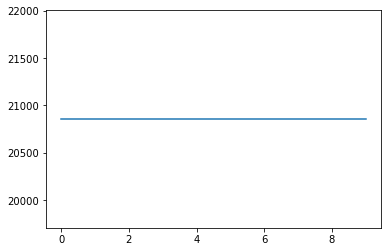

In [ ]:
train = []
test = []
gamma = np.arange(0,10,1)
overfit = []
for i in gamma:
    params = {"max_depth":5,"seed":1412,"eta":0.1
              ,"gamma":float(i)
             }
    result = xgb.cv(params,data_xgb,num_boost_round=100
                ,nfold=5 #补充交叉验证中所需的参数，nfold=5表示5折交叉验证
                ,seed=1412 #交叉验证的随机数种子，params中的是管理boosting过程的随机数种子
               )
    overfit.append(overfitcheck(result))
    train.append(result.iloc[-1,0])
    test.append(result.iloc[-1,2])
plt.plot(gamma,overfit);

绘制gamma与train的图像再观察：

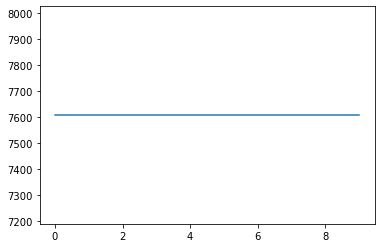

In [ ]:
plt.plot(gamma,train);

如上所示，训练集结果纹丝不动，过拟合程度也纹丝不动。这是不是`gamma`失效了呢？实际上，**对于没有上限或下限的参数，我们要关注参数的敏感度。**如果参数值稍稍移动，模型就变化很大，那参数敏感，如果参数值移动很多，模型才能有变化，那参数不敏感。当树的结构相对复杂时，`gamma`会比敏感，否则`gamma`可能非常迟钝。当原始标签数值很大、且叶子数量不多时，`lambda`和`alpha`就会敏感，如果原始标签数值很小，这两个参数就不敏感。因此在使用这些参数之前，最好先对参数的敏感程度有一个探索，这里很容易看到：

- 当前树结构不复杂，`gamma`不敏感

In [ ]:
train = []
test = []
gamma = np.arange(0,10000000,1000000)
overfit = []
for i in gamma:
    params = {"max_depth":5,"seed":1412,"eta":0.1
              ,"gamma":float(i)
              #,"lambda":400
             }
    result = xgb.cv(params,data_xgb,num_boost_round=100
                ,nfold=5 #补充交叉验证中所需的参数，nfold=5表示5折交叉验证
                ,seed=1412 #交叉验证的随机数种子，params中的是管理boosting过程的随机数种子
               )
    overfit.append(overfitcheck(result))
    train.append(result.iloc[-1,0])
    test.append(result.iloc[-1,2])

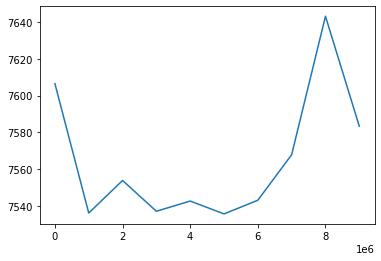

In [ ]:
plt.plot(gamma,train);

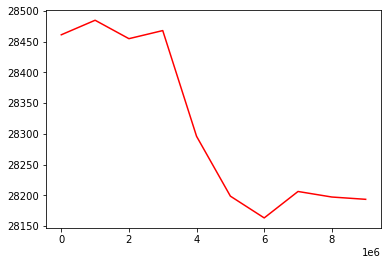

In [ ]:
plt.plot(gamma,test,color="red");

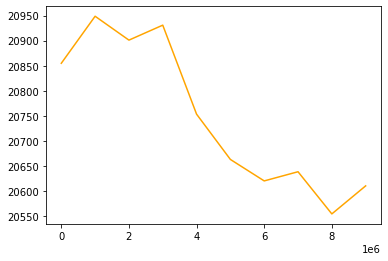

In [ ]:
plt.plot(gamma,overfit,color="orange");

`gamma`控制过拟合的最好成绩：

In [ ]:
min(overfit)

20554.4015628

- 当前标签值较大，因此预测标签的值也较大，`lambda`会更敏感

In [ ]:
y.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [ ]:
train = []
test = []
lambda_ = np.arange(1,2,0.1)
overfit = []
for i in lambda_:
    params = {"max_depth":5,"seed":1412,"eta":0.1
              ,"lambda":float(i)
             }
    result = xgb.cv(params,data_xgb,num_boost_round=100
                ,nfold=5 #补充交叉验证中所需的参数，nfold=5表示5折交叉验证
                ,seed=1412 #交叉验证的随机数种子，params中的是管理boosting过程的随机数种子
               )
    overfit.append(overfitcheck(result))
    train.append(result.iloc[-1,0])
    test.append(result.iloc[-1,2])

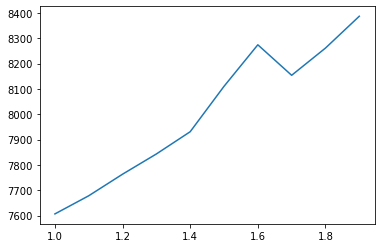

In [ ]:
plt.plot(lambda_,train);

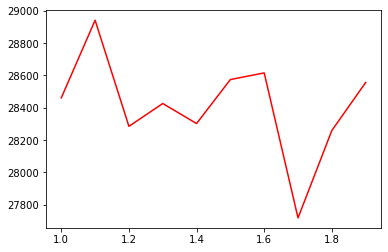

In [ ]:
plt.plot(lambda_,test,color="red");

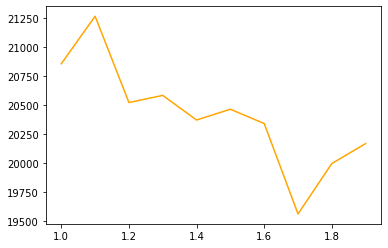

In [ ]:
plt.plot(lambda_,overfit,color="orange");

`lambda`控制过拟合的最好成绩：

In [ ]:
min(overfit)

19564.888281400003

可见，现在`lambda`比`gamma`有效。当然，在实际使用时，并不是在所有数据情况下都如此，需要根据具体情况具体分析。因此在使用和调节这些参数时，要先考虑适合的参数范围，否则再多的搜索也是无用。总结一下，在整个迭代过程中，我们涉及到了如下参数：

|类型|参数|
|---|---|
|**迭代过程/损失函数**|num_boost_round：集成算法中弱分类器数量，对Boosting算法而言为实际迭代次数<br><br>eta：Boosting算法中的学习率，影响弱分类器结果的加权求和过程<br><br><font color="green">**objective**</font>：选择需要优化的损失函数<br><br><font color="green">**base_score**</font>：初始化预测结果$H_0$的设置<br><br><font color="green">**max_delta_step**</font>：一次迭代中所允许的最大迭代值<br><br><font color="green">**gamma**</font>：乘在叶子数量前的系数，放大可控制过拟合<br><br><font color="green">**lambda**</font>：L2正则项系数，放大可控制过拟合<br><br><font color="green">**alpha**</font>：L1正则项系数，放大可控制过拟合|

## 2 XGBoost的弱评估器

### 2.1 三大评估器与DART树

梯度提升算法当中不只有梯度提升树，也可集成其他模型作为弱评估器，而作为梯度提升树进化版的XGBoost算法，自然也不是只有CART树一种弱评估器。在XGBoost当中，我们还可以选型线性模型，比如线性回归或逻辑回归来集成，同时还可以选择与CART树有区别的另一种树：DART树。在XGBoost当中，我们使用参数`booster`来控制我们所使用的具体弱评估器。

- 参数`booster`：使用哪种弱评估器。
> 可以输入"gbtree"、"gblinear"或者"dart"。<br><br>
> 输入"gbtree"表示使用遵循XGBoost规则的CART树，我们之前提到的XGBoost在GBDT上做出的改善基本都是针对这一类型的树。这一类型的树又被称为“XGBoost独有树”，XGBoost Unique Tree。<br><br>
> 输入"dart"表示使用抛弃提升树，DART是Dropout Multiple Additive Regression Tree的简称。这种建树方式受深度学习中的Dropout技巧启发，在建树过程中会随机抛弃一些树的结果，可以更好地防止过拟合。在数据量巨大、过拟合容易产生时，DART树经常被使用，但由于会随机地抛弃到部分树，可能会伤害模型的学习能力，同时可能会需要更长的迭代时间。<br><br>
> 输入"gblinear"则表示使用线性模型，当弱评估器类型是"gblinear"而损失函数是MSE时，表示使用xgboost方法来集成线性回归。当弱评估器类型是"gblinear"而损失函数是交叉熵损失时，则代表使用xgboost来集成逻辑回归。<br><br>
> 每一种弱评估器都有自己的params列表，例如只有树模型才会有学习率等参数，只有DART树才会有抛弃率等参数。评估器必须与params中的参数相匹配，否则一定会报错。其中，由于DART树是从gbtree的基础上衍生而来，因此gbtree的所有参数DART树都可以使用。

|参数含义|原生代码|sklearn API|
|:-:|:-:|:-:|
|选择使用不同的弱评估器|**booster**<br>(params)|**booster**|

在上述三种树当中，DART树的参数需要单独进行说明。DART树的建树过程与普通提升树gbtree完全一致，但在集成树结果的过程中与传统gbtree有所区别。具体地来说，提升树的模型输出结果往往等于所有树结果的加权求和：

$$H(x_i) =  \sum_{k=1}^\boldsymbol{\color{red}K}f_k(x_i)$$

在第$k$次迭代中建立新的树时，迭代后的结果等于之前所有${k-1}$棵树的结果加新建立的树的结果:

$$H_k(x_i) = H_{k-1}(x_i) + \boldsymbol{\color{red}\eta} f_k(x_i)$$

DART树在**每一次迭代**前都会随机地抛弃部份树，即不让这些树参与$H_{k-1}(x_i)$的计算，这种随机放弃的方式被叫做“Dropout”（抛弃）。举例说明，假设现在一共有5棵树，结果分别如下：

||k=1|k=2|k=3|k=4|k=5|
|:-:|:-:|:-:|:-:|:-:|:-:|
|$\eta f_k(x_i)$|1|0.8|0.6|0.5|0.3|

当建立第6棵树时，普通提升树的$H_{k-1}(x_i)$ = 1+0.8+0.6+0.5+0.3 = 3.2。对于DART树来说，我们可以认为设置抛弃率`rate_drop`，假设抛弃率为0.2，则DART树会随机从5棵树中抽样一棵树进行抛弃。假设抛弃了第二棵树，则DART树的$H_{k-1}(x_i)$ = 1+0.6+0.5+0.3 = 2.4。通过影响$H_{k-1}(x_i)$，DART树影响损失函数、影响整个算法的输出结果$H(x)$，以此就可以在每一次迭代中极大程度地影响整个xgboost的方向。

在一般的抗过拟合方法当中，我们只能从单棵树的学习能力角度入手花式对树进行剪枝，但DART树的方法是对整体迭代过程进行控制。在任意以“迭代”为核心的算法当中，我们都面临同样的问题，即**最开始的迭代极大程度地影响整个算法的走向，而后续的迭代只能在前面的基础上小修小补**。这一点从直觉上来说很好理解，毕竟当我们在绘制损失函数的曲线时，会发现在刚开始迭代时，损失函数急剧下降，但随后就逐渐趋于平缓。在这个过程中，没有任何过拟合手段可以从流程上影响到那些先建立的、具有巨大影响力的树，但DART树就可以削弱这些前端树的影响力，大幅提升抗过拟合的能力。

在这个过程中，我们涉及到以下的几个参数：

- 参数`rate_drop`：每一轮迭代时抛弃树的比例
> 设置为0.3，则表示有30%的树会被抛弃。只有当参数`booster`="dart"时能够使用，只能填写[0.0,1.0]之间的浮点数，默认值为0。
- 参数`one_drop`：每一轮迭代时至少有`one_drop`棵树会被抛弃
> 可以设置为任意正整数，例如`one_drop` = 10，则意味着每轮迭代中至少有10棵树会被抛弃。<br><br>
> 当参数`one_drop`的值高于`rate_drop`中计算的结果时，则按照`one_drop`中的设置执行Dropout。例如，总共有30棵树，`rate_drop`设置为0.3，则需要抛弃9棵树。但`one_drop`中设置为10，则一定会抛弃10棵树。当`one_drop`的值低于`rate_drop`的计算结果时，则按`rate_drop`的计算结果执行Dropout。
- 参数`skip_drop`：每一轮迭代时可以不执行dropout的概率
> 即便参数`booster`='dart'，每轮迭代也有`skip_drop`的概率可以不执行Dropout，是所有设置的概率值中拥有最高权限的参数。该参数只能填写[0.0,1.0]之间的浮点数，默认值为0。当该参数为0时，则表示每一轮迭代都一定会抛弃树。如果该参数不为0，则有可能不执行Dropout，直接按照普通提升树的规则建立新的提升树。<br><br>
> 需要注意的是，`skip_drop`的权限高于`one_drop`。即便`one_drop`中有所设置，例如每次迭代必须抛弃至少10棵树，但只要`skip_drop`不为0，每轮迭代则必须经过`skip_drop`的概率筛选。如果`skip_drop`说本次迭代不执行Dropout，则忽略`one_drop`中的设置。
- 参数`sample_type`：抛弃时所使用的抽样方法
> 填写字符串"uniform"：表示均匀不放回抽样。<br><br>
> 填写字符串"weighted"：表示按照每棵树的权重进行有权重的不放回抽样。<br><br>
> 注意，该不放回是指在一次迭代中不放回。**每一次迭代中的抛弃是相互独立的，因此每一次抛弃都是从所有树中进行抛弃**。上一轮迭代中被抛弃的树在下一轮迭代中可能被包括。
- 参数`normalize_type`：增加新树时，赋予新树的权重
> 当随机抛弃已经建好的树时，可能会让模型结果大幅度偏移，因此往往需要给与后续的树更大的权重，让新增的、后续的树在整体算法中变得更加重要。所以DART树在建立新树时，会有意地给与后续的树更大的权重。我们有两种选择：<br><br>
> 填写字符串"tree"，表示新生成的树的权重等于所有被抛弃的树的权重的均值。<br><br>
> 填写字符串"forest"，表示新生成的树的权重等于所有被抛弃的树的权重之和。
> 算法默认为"tree"，当我们的dropout比例较大，且我们相信希望给与后续树更大的权重时，会选择"forest"模式。

你是否注意到，我们的两个参数`sample_type`与`normalize_type`都使用了概念“树的权重”，但我们在之前讲解XGBoost的基本流程时提到过，XGBoost并不会针对每一棵树计算特定的权重。这个**树的权重其实指的是整棵树上所有叶子权重之和**。那究竟是怎样让新增加的树的权重刚好就等于原本被抛弃的树的权重的均值或和呢？这就需要一个相对复杂的数学过程来进行解答了，如果你感兴趣，可以查看这一篇说明：https://xgboost.readthedocs.io/en/stable/tutorials/dart.html

当我们在应用的时候，这个点并不会对我们造成影响，只要知道参数如何使用即可。**同时，所有dart树相关的参数在原生代码与sklearn代码中都完全一致**。

当模型容易过拟合时，我们可以尝试让模型使用DART树来减轻过拟合。不过DART树也会带来相应的问题，最明显的缺点就是：

- 用于微调模型的一些树可能被抛弃，微调可能失效
- 由于存在随机性，模型可能变得不稳定，因此提前停止等功能可能也会变得不稳定
- 由于要随机抛弃一些树的结果，在工程上来说就无法使用每一轮之前计算出的$H_{k-1}$，而必须重新对选中的树结果进行加权求和，可能导致模型迭代变得略微缓慢

In [ ]:
data_xgb = xgb.DMatrix(X,y)
params_dart = {"max_depth":5 ,"seed":1412, "eta":0.1
                  ,"booster":"dart","sample_type": "uniform"
                  ,"normalize_type":"tree"
                  ,"rate_drop": 0.2
                  ,"skip_drop": 0.5}
result_dart = xgb.cv(params_dart,data_xgb,num_boost_round=100
                ,nfold=5 #补充交叉验证中所需的参数，nfold=5表示5折交叉验证
                ,seed=1412 #交叉验证的随机数种子，params中的是管理boosting过程的随机数种子
               )

In [ ]:
result_dart.iloc[-1,:]

train-rmse-mean     9906.142188
train-rmse-std       317.321406
test-rmse-mean     28262.178906
test-rmse-std       8082.918652
Name: 99, dtype: float64

In [ ]:
overfitcheck(result_dart)

18356.036718800002

可以看出，dart树抗过拟合效果比`gamma`、`lambda`等参数更强，不过在提升模型的测试集表现上，dart树还是略逊一筹，毕竟dart树会伤害模型的学习能力。

### 2.2 弱评估器的分枝

当参数`booster`的值被设置为gbtree时，XGBoost所使用的弱评估器是改进后的的CART树，其分枝过程与普通CART树高度一致：向着叶子质量提升/不纯度下降的方向分枝、并且每一层都是二叉树。在CART树的基础上，XGBoost创新了全新的分枝指标：**结构分数（Structure Score）与结构分数增益（Gain of Structure Score）**（也被叫做结构分数之差），更大程度地保证了CART树向减小目标函数的方向增长。需要注意的是，**XGBoost不接受其他指标作为分枝指标**，因此你会发现在众多的xgboost的参数中，并不存在`criterion`参数：

|类型|参数|
|-|-|
|**迭代过程/目标函数**|**params**: eta, base_score, objective, <font color="green">**lambda, gamma, alpha, max_delta_step**</font><br>**xgb.train()**: num_boost_round|
|**弱评估器结构**|**params**: max_depth, <font color="green">**booster, min_child_weight**</font>|
|**dart树**|**params**: <font color="green">**sample_type, normalized_type, rate_drop, one_drop, skip_drop**</font>|
|**弱评估器的训练数据**|**params**: subsample, <font color="green">**sampling_method, colsamle_bytree, colsample_bylevel, colsample_bynode**</font>|
|**提前停止**|**xgb.train()**: <font color="green">**early_stopping_rounds, evals**</font>, eval_metric|
|**其他**|**params**: seed, <font color="green">**verbosity, scale_pos_weight, nthread**</font>|

<br>幸运的是，没有任何参数与结构分数的公式本身相关，因此从应用xgboost的角度来看，我们并不需要对结构分数以及相应的分枝过程理解太深，只需对公式稍作了解即可。不过，结构分数是XGBoost整个运行流程中非常核心的概念，它即精又巧，串起了整个XGBoost几乎所有的数学流程。在原始论文中，作者陈天奇使用了一整节的篇幅来推导结构分数的公式，因此这部分原理非常值得学习。如果你渴望学习相关原理，可以查看数学的最后一节。现在，我们来了解结构分数的相关公式：

**假设现在目标函数使用L2正则化，控制叶子数量的参数`gamma`为0。现在存在一个叶子节点$j$，对该节点来说结构分数的公式为：**

$$ Score_j = \frac{(\sum_{i \in j}g_i)^2}{\sum_{i \in j}h_i + \lambda}$$

其中，$g_i$是样本$i$在损失函数$L$上对预测标签求的一阶导数，$h_i$是样本$i$在损失函数$L$上对预测标签求的二阶导数，$i \in j$表示对叶子$j$上的所有样本进行计算，$\lambda$就是L2正则化的正则化系数。所以不难发现，结构分数实际上就是：

$$Score_j = \frac{节点j上所有样本的一阶导数之和的平方}{节点j上所有样本的二阶导数之和 + \lambda}$$

需要注意结构分数是针对节点计算的，我们以前学习的不纯度衡量指标如基尼系数、信息熵等也是如此。在此基础上，我们依赖于结构分数增益进行分枝，结构分数增益表现为：

$$\begin{align}
Gain &= Score_L + Score_R - Score_P \\ \\
&= \frac{(\sum_{i \in L}g_i)^2}{\sum_{i \in L}h_i + \lambda} + \frac{(\sum_{i \in R}g_i)^2}{\sum_{i \in R}h_i + \lambda} - \frac{(\sum_{i \in P}g_i)^2}{\sum_{i \in P}h_i + \lambda}\\ \\
&（见原论文7号公式）
\end{align}$$

这即是说，结构分数增益实际上就是：

$$Gain = 左节点的结构分数 + 右节点的结构分数 - 父节点的结构分数$$

**我们选择增益$Gain$最大的点进行分枝**。

你是否注意到，XGBoost中的分枝规则与经典CART树的分枝规则在细节上有所不同？CART树中所使用的信息增益是：

$$CART树中的信息增益 = 父节点的不纯度 - （左节点的不纯度 + 右节点的不纯度）$$

我们追求的是最大的信息增益，这意味着随着CART树的建立整体不纯度是在逐渐降低的。无论不纯度衡量指标是基尼系数还是信息熵，不纯度是越小越好。然而在XGBoost当中，增益的计算公式与CART树相反，但我们依然追求最大增益，所以这意味着**随着XGBoost树的建立，整体结构分数是逐渐上升的**。因此我们可以认为**结构分数越大越好**。

那结构分数的含义是什么呢？它也像信息熵一样，可以衡量叶子节点的某种属性吗？为什么结构分数需要越大越好呢？这些问题需要大家了解数学推导过程后才能解答，但我们在这里可以举一个很简单的例子来证实结构分数增益越大、选出的分枝越好。

假设现在我们有一个超简单的节点需要分割，该节点中所包含的样本如下：

|样本|y|y_hat|
|:-:|:-:|:-:|
|1|1|0.5|
|2|-2|0.5|
|3|-2|0.5|

**众所周知，在决策树中一个节点只能有一个输出值，因此同一片叶子上所有样本的预测值都一致**，不同的树模型使用不同的方法来计算叶子节点上的输出值，大部分模型都直接使用样本的真实值的均值作为输出，但XGBoost有自己不同的手段。现在我们可以暂时忽略这一点，先假设当前的节点预测值为0.5。

现在要对该节点进行分割，你知道从哪里分枝会最有效吗？因为一片叶子只会输出一个预测值，所以相同标签的样本最好在一片叶子上。因此很明显，因为2、3号叶子的真实值一致，我们应该将该节点从1号样本和2号样本中间分开，让1号样本单独在一片叶子上，而2、3号样本在一片叶子上（1，23）。但实际在进行分枝时，我们需要尝试所有可能的方式，并分别计算以下方式的结构分数增益：

- 分割方案1:（1,23）

|左子节点|y|y_hat||右子节点|y|y_hat|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|1|1|0.5||2|-2|0.5|
|||||3|-2|0.5|

- 分割方案2:（12,3）

|左子节点|y|y_hat||右子节点|y|y_hat|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|1|1|0.5||3|-2|0.5|
|2|-2|0.5|||||

假设现在执行的是XGBoost回归，损失函数为0.5倍MSE，公式为$\frac{1}{2}(y - \hat{y})^2$，假设lambda=1。那基于MSE的一阶导数为：

$$\begin{align}
l&= \frac{1}{2}(y_i - \hat{y_i})^2 \\ \\ 
l' &= \frac{\partial}{\partial \hat{y_i}} \frac{1}{2}(y_i - \hat{y_i})^2\\ \\
&= - (y_i - \hat{y_i})\\ \\
&= \hat{y_i} - y_i\\ \\
\end{align}$$

基于MSE的二阶导数为：

$$\begin{align}
l'' &= \frac{\partial}{\partial \hat{y_i}} (\hat{y_i} - y_i)\\ \\
&= 1
\end{align}$$

因此无论如何划分，$g_i = \hat{y_i} - y_i$，$h_i = 1$。现在来计算父节点和两个子节点上每个样本的$g_i$与$h_i$：

- 父节点：

|样本|y|y_hat|gi|hi|
|:-:|:-:|:-:|:-:|:-:|
|1|1|0.5|-0.5|1|
|2|-2|0.5|2.5|1|
|3|-2|0.5|2.5|1|

因此父节点的结构分数为：

$$\begin{align}
Score_P &= \frac{(\sum_{i \in P}g_i)^2}{\sum_{i \in P}h_i + \lambda} \\ \\
&= \frac{(-0.5 + 2.5 + 2.5)^2}{3 + 1} \\ \\
&= 5.0625
\end{align}$$

- 方案1

|左子节点|y|y_hat|gi|hi||右子节点|y|y_hat|gi|hi|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|1|1|0.5|-0.5|1||2|-2|0.5|2.5|1|
|||||||3|-2|0.5|2.5|1|

方案1下两个子节点的结构分数为：

$$\begin{align}
Score_{L1} &= \frac{(\sum_{i \in {L1}}g_i)^2}{\sum_{i \in {L1}}h_i + \lambda} \\ \\
&= \frac{(-0.5)^2}{1 + 1} \\ \\
&= 0.125
\end{align}$$

<br>

$$\begin{align}
Score_{R1} &= \frac{(\sum_{i \in {R1}}g_i)^2}{\sum_{i \in {R1}}h_i + \lambda} \\ \\
&= \frac{(2.5+2.5)^2}{2 + 1} \\ \\
&= 8.333
\end{align}$$

因此增益等于：

$$\begin{align}
Gain &= Score_{L1} + Score_{R1} - Score_P \\ \\
&= 0.125 + 8.333 - 5.6025 \\ \\
&= 3.395
\end{align}$$

- 方案2

|左子节点|y|y_hat|gi|hi||右子节点|y|y_hat|gi|hi|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|1|1|0.5|-0.5|1||3|-2|0.5|2.5|1|
|2|-2|0.5|2.5|1|||||||

方案1下两个子节点的结构分数为：

$$\begin{align}
Score_{L1} &= \frac{(\sum_{i \in {L1}}g_i)^2}{\sum_{i \in {L1}}h_i + \lambda} \\ \\
&= \frac{(-0.5 + 2.5)^2}{2 + 1} \\ \\
&= 1.333
\end{align}$$

<br>

$$\begin{align}
Score_{R1} &= \frac{(\sum_{i \in {R1}}g_i)^2}{\sum_{i \in {R1}}h_i + \lambda} \\ \\
&= \frac{(2.5)^2}{1 + 1} \\ \\
&= 3.125
\end{align}$$

因此增益等于：

$$\begin{align}
Gain &= Score_{L1} + Score_{R1} - Score_P \\ \\
&= 1.333 + 3.125 - 5.0625 \\ \\ 
&= -0.604
\end{align}$$

|方案|左侧结构分数|右侧结构分数|父节点结构分数|增益|
|:-:|:-:|:-:|:-:|:-:|
|**(1,23)**|0.125|8.333|5.0625|<font color="green">**3.3958**</font>|
|**(12,3)**|1.333|3.125|5.0625|-0.6041|

很明显，方案1（1,23）的增益为3.395，远远大于方案2（12，3）的增益-0.604，因此根据结构分数增益的指示，我们应该使用第一种分割方式，这与我们经验判断的一致。在XGBoost建树过程中，我们需要对每一个节点进行如上计算，不断来选出令增益更大的分枝。

- 结构分数与信息熵的关键区别

不知道你是否注意到一个问题。在之前我们提到过，结构分数是越大越好。在方案1当中，左侧叶子节点上的结构分数为0.125，右侧叶子节点上的结构分数为8.333，这是否意味着左侧叶子比右侧叶子更好呢？**答案是否定的。与信息熵、基尼系数等可以评价单一节点的指标不同，结构分数只能够评估结构本身的优劣，不能评估节点的优劣**。

比如说，方案1中的树结构有更高的分数之和，方案2中的树结构的分数之和较低，所以方案1更好。但我们不能说，方案1中的左节点分数低，右节点分数高，所以右节点比左节点更好。因此，在XGBoost原始论文当中，**我们利用一棵树上所有叶子的结构分数之和来评估整棵树的结构的优劣**，分数越高则说明树结构质量越高，因此在原论文中，结构分数也被称为质量分数（quality score）。

### 2.3 控制复杂度（一）：弱评估器的剪枝

对于树模型，除了了解树是如何建立的，也需要了解如何控制树的整体结构复杂度。一般来说，控制树模型复杂度的方式有两种：一种是对树进行剪枝，一种是从训练数据上下功夫。本节我们先来看弱评估器的剪枝。

与其他树模型中五花八门的剪枝参数不同，XGBoost只有三个剪枝参数和一个侧面影响树生长的参数，其中最为我们熟知的剪枝参数是`max_depth`，它的用法与其他树模型中一致，在XGBoost中默认值为6，因此在对抗过拟合方面影响力不是很大。需要重点来说明的是以下三个参数：

- 参数`min_child_weight`：可以被广义理解为任意节点上所允许的样本量（样本权重）。
> 更严谨的说法是，`min_child_weight`是在任意节点$j$上所允许的最小的$\sum_{i \in j}h_i$值。如果一个节点上的$\sum_{i \in j}h_i$小于该参数中设置的值，该节点被剪枝。<br><br>
> 如果你仔细学习了上一节内容，你会很容易理解$\sum_{i \in j}h_i$其实就是结构分数的分母：<br><br>
> $$ Score_j = \frac{(\sum_{i \in j}g_i)^2}{\sum_{i \in j}h_i + \lambda}$$<br>
> 其中，$h_i$是样本$i$的损失函数$l$在预测值$f(x_i)$上的二阶导数，$\sum_{i \in j}h_i$就是该节点上所有样本的$h_i$之和。<br><br>
> 在上一节中，假设损失函数为$\frac{1}{2}MSE$，我们推导出任意样本的$h_i = 1$，因此$\sum_{i \in j}h_i$应该等于该叶子节点上的总样本量。因为这个原因，$h_i$在XGBoost原始论文和官方说明中有时被称为“样本权重”（instance weight）。因此，当MSE为损失函数时，参数`min_child_weight`很类似于sklearn中的`min_sample_leaf`，即一个节点上所允许的最小样本量。<br><br>
> 然而，如果我们使用的损失函数不是MSE，那$h_i$也就不会等于1了。不过官方依然将$h_i$称之为样本权重，当损失函数更换时，样本的权重也随之变化。当损失函数不为MSE时，参数`min_child_weight`时一个节点上所允许的最小样本权重量。<br><br>
> 很显然，参数`min_child_weight`越大，模型越不容易过拟合，同时学习能力也越弱。

- 参数`gamma`：目标函数中叶子数量$T$前的系数，同时也是允许分枝的最低结构分数增益。当分枝时结构增益不足`gamma`中设置的值，该节点被剪枝。
> 在目标函数当中，`gamma`是叶子数量$T$前的系数，放大gamma可以将目标函数的重点转移至结构风险，从而控制过拟合：<br><br>
> $$Obj_k = \sum_{i=1}^Ml(y_i,\hat{y_i}) + \boldsymbol{\color{red}\gamma} T + \frac{1}{2}\boldsymbol{\color{red}\lambda}\sum_{j=1}^Tw_j^2 + \boldsymbol{\color{red}\alpha}\sum_{j=1}^Tw_j$$ <br>
> 在上一节中介绍结构分数时，我们曾做出假设`gamma`为0，当`gamma`不为0时，结构分数增益的公式如下：<br><br>
> $$\begin{align}
Gain &= \frac{1}{2} ( Score_L + Score_R - Score_P ) - \gamma \\ \\
&= \frac{1}{2} \left( \frac{(\sum_{i \in L}g_i)^2}{\sum_{i \in L}h_i + \lambda} + \frac{(\sum_{i \in R}g_i)^2}{\sum_{i \in R}h_i + \lambda} - \frac{(\sum_{i \in P}g_i)^2}{\sum_{i \in P}h_i + \lambda} \right) - \gamma
\end{align}$$ <br>
> 在XGBoost中，我们追求一棵树整体的结构分数最大，因此XGBoost规定**任意结构的分数增益不能为负，任意增益为负的节点都会被剪枝**，因此可以默认有：<br><br>
> $$\frac{1}{2} \left( \frac{(\sum_{i \in L}g_i)^2}{\sum_{i \in L}h_i + \lambda} + \frac{(\sum_{i \in R}g_i)^2}{\sum_{i \in R}h_i + \lambda} - \frac{(\sum_{i \in P}g_i)^2}{\sum_{i \in P}h_i + \lambda} \right) - \gamma > 0$$<br>
> 因此：$$\frac{1}{2} \left( \frac{(\sum_{i \in L}g_i)^2}{\sum_{i \in L}h_i + \lambda} + \frac{(\sum_{i \in R}g_i)^2}{\sum_{i \in R}h_i + \lambda} - \frac{(\sum_{i \in P}g_i)^2}{\sum_{i \in P}h_i + \lambda} \right) > \gamma
$$<br>
> 这是说，当参数`gamma`为0时，任意增益为负的节点都会被剪枝。当`gamma`为任意正数时，任意增益小于`gamma`设定值的节点都会被剪枝。不难发现，`gamma`在剪枝中的作用就相当于sklearn中的`min_impurity_decrease`。<br><br>
> 很显然，`gamma`值越大，算法越不容易过拟合，同时学习能力也越弱。

- 参数`lambda`和`alpha`：正则化系数，同时也位于结构分数中间接影响树的生长和分枝。
> 当使用L2正则化时，结构分数为：<br><br>
> $$ Score_j = \frac{(\sum_{i \in j}g_i)^2}{\sum_{i \in j}h_i + \lambda}$$<br>
> 然而，当使用L1正则化时，结构分数为：<br><br>
> $$ Score_j = \frac{(\sum_{i \in j}g_i)^2 + \alpha}{\sum_{i \in j}h_i}$$<br>
> 因此，当`lambda`越大，结构分数会越小，参数`gamma`的力量会被放大，模型整体的剪枝会变得更加严格，同时，由于`lambda`还可以通过目标函数将模型学习的重点拉向结构风险，因此`lambda`具有双重扛过拟合能力。<br><br>
> 然而，当`alpha`越大时，结构分数会越大，参数`gamma`的力量会被缩小，模型整体的剪枝会变得更宽松。然而，`alpha`还可以通过目标函数将模型学习的重点拉向结构风险，因此`alpha`会通过放大结构分数抵消一部分扛过拟合的能力。整体来看，`alpha`是比`lambda`更宽松的剪枝方式。<br><br>
> 在XGBoost当中，我们可以同时使用两种正则化，则结构分数为：<br><br>
> $$ Score_j = \frac{(\sum_{i \in j}g_i)^2 + \alpha}{\sum_{i \in j}h_i + \lambda}$$<br>
> 此时，影响模型变化的因子会变得过多，我们难以再从中找到规律，调参会因此变得略有困难。但是当你感觉到L2正则化本身不足以抵抗过拟合的时候，可以使用L1+L2正则化的方式尝试调参。

不难发现，由于在目标函数中加入了正则项和控制叶子数量的结构风险项，XGBoost控制过拟合的方式与其他树模型差异很大。在之后调参的章节当中，我们将尝试将上述4个参数共同调参。

### 2.4 控制复杂度（二）：弱评估器的训练数据

除了通过剪枝来控制模型复杂度之外，XGBoost也继承了GBDT和随机森林的优良传统：可以通过对样本和特征进行抽样来增加弱评估器多样性、从而控制过拟合。在这一部分所使用的参数都是我们曾经见过的，只不过在XGBoost当中，我们可以进行更丰富的数据抽样。具体来看：

**样本的抽样**

- 参数`subsample`：对样本进行抽样的比例，默认为1，可输入(0,1]之间的任何浮点数。例如，输入0.5，则表示随机抽样50%的样本进行建树。
> 当该参数设置为1时，表示使用原始数据进行建模，不进行抽样。同时，**XGBoost中的样本抽样是不放回抽样**，因此不像GBDT或者随机森林那样存在袋外数据的问题，同时也无法抽样比原始数据更多的样本量。因此，抽样之后样本量只能维持不变或变少，如果样本量较少，建议保持`subsample`=1。
- 参数`sampling_method`：对样本进行抽样时所使用的抽样方法，默认均匀抽样。
> 输入"uniform"：表示使用均匀抽样，每个样本被抽到的概率一致。如果使用均匀抽样，建议`subsample`的比例最好在0.5或以上。<br><br>
> 需要注意的是，该参数还包含另一种可能的输入"gradient_based"：表示使用有权重的抽样，并且每个样本的权重等于该样本的$\sqrt{g_i^2 +\lambda h_i^2}$。但该输入目前还不支持XGBoost当中主流的gbtree等建树方法，因此一般我们不会用到。

**特征的抽样**

- 参数`colsample_bytree`，`colsample_bylevel`，`colsample_bynode`，这几个参数工沟通控制对特征所进行的抽样。
> 所有形似`colsample_by*`的参数都是抽样比例，可输入(0,1]之间的任何浮点数，默认值都为1。<br><br>
> 对于GBDT、随机森林来说，特征抽样是发生在每一次建树之前。但对XGBoost来说，特征的抽样可以发生在建树之前（由`colsample_bytree`控制）、生长出新的一层树之前（由`colsample_bylevel`控制）、或者每个节点分枝之前（由`colsample_bynode`控制）。<br><br>
> 三个参数之间会互相影响，**全特征集 >= 建树所用的特征子集 >= 建立每一层所用的特征子集 >= 每个节点分枝时所使用的特征子集**。<br><br>
> 举例说明：假设原本有64个特征，参数`colsample_bytree`等于0.5，则用于建树的特征就只有32个。此时，如果`colsample_bylevel`不为1，也为0.5，那新建层所用的特征只能由16个，并且**这16个特征只能从当前树已经抽样出的32特征中选择**。同样的，如果`colsample_bynode`也不为1，为0.5，那每次分枝之前所用的特征就只有8个，并且这8个特征只能从当前层已经抽样出的16个特征中选择。<br><br>
> 在实际使用时，我们可以让任意抽样参数的比例为1，可以在某一环节不进行抽样。一般如果特征量太少（例如，10个以下），不建议同时使用三个参数。

现在我们已经详细介绍了XGBoost当中最简单的弱评估器，按照CART树规则或DART树规则、使用结构分数增益进行分枝的树在XGBoost的系统中被称为“贪婪树”（Greedy Tree）。大部分时候我们都会使用贪婪树来运行XGBoost算法，但在XGBoost当中还有其他几种不同的建树模式，包括基于直方图的估计贪婪树（approx greedy tree）、快速直方图贪婪树（Fast Histogram Approximate Greedy Tree）、以及基于GPU运行的快速直方图贪婪树等内容。这些算法在XGBoost原始论文中占了较大篇幅，并且在后续的LightGBM算法中被发扬光大，我们将在LGBM算法中详细讲解直方图方法。在使用XGBoost时，我们将专注于贪婪树本身。

到这里，关于XGBoost弱评估器的内容就全部讲解完毕了，总结一下，我们学习了如下参数：

|类型|参数|
|---|---|
|**弱评估器**|<font color="green">**booster**</font>：选择迭代过程中的弱评估器类型，包括gbtree，DART和线性模型<br><br><font color="green">**sample_type**</font>：DART树中随机抽样树的具体方法<br><br><font color="green">**rate_drop**</font>：DART树中所使用的抛弃率<br><br><font color="green">**one_drop**</font>：每轮迭代时至少需要抛弃的树的数量<br><br><font color="green">**skip_drop**</font>：在迭代中不进行抛弃的概率<br><br><font color="green">**normalized_type**</font>：根据被抛弃的树的权重控制新增树权重<br><br>max_depth：允许的弱评估器的最大深度<br><br><font color="green">**min_child_weight**：</font>（广义上）叶子节点上的最小样本权重/最小样本量<br><br><font color="green">**gamma**</font>：目标函数中叶子数量$T$的系数，同时也是分枝时所需的最小结构分数增益值<br><br><font color="green">**lambda**与**alpha**</font>：正则项系数，同时也位于结构分数的公式中，间接影响模型的剪枝<br><br><font color="green">**sample_type**</font>：对样本进行抽样具体方式<br><br><font color="green">**subsample**</font>：对样本进行抽样的具体比例<br><br><font color="green">**colsample_bytree, colsample_bylevel, colsample_bynode**</font>：在建树过程中对特征进行抽样的比例|

需要注意的是，以上全部参数都需要被写在parmas中，没有任何需要写在`xgb.train`或`xgb.cv`中的参数，故而没有给大家呈现具体的代码。在后续调参章节中，我们将展示使用这些参数的代码。

## 3 XGBoost的其他参数与方法

目前为止，我们已经将与XGBoost的训练、建树相关的参数全部讲解完毕了，剩余的参数是一些功能性的参数，如果你已经熟悉课程中其他算法，那这些参数对你来说应该非常容易，包括：

- **提前停止**
> 参数`early_stopping_rounds`：位于`xgb.train`方法当中。如果规定的评估指标不能连续`early_stopping_rounds`次迭代提升，那就触发提前停止。

- **模型监控与评估**
> 参数`evals`：位于`xgb.train`方法当中，用于规定训练当中所使用的评估指标，一般都与损失函数保持一致，也可选择与损失函数不同的指标。该指标也用于提前停止。<br><br>
> 参数`verbosity`：用于打印训练流程和训练结果的参数。在最早的版本中该参数为silent，后来经过更新变成了今天的verbosity。然而，经过改进之后的verbosity更倾向于帮助我们打印建树相关的信息，而不像原来的silent一样帮助我们展示训练过程中的模型评估信息，因此verbosity现在不那么实用了。
>> 我们可以在verbosity中设置数字[0,1,2,3]，参数默认值为1。<br>
>> - 0：不打印任何内容<br>
>> - 1：表示如果有警告，请打印警告<br>
>> - 2：请打印建树的全部信息<br>
>> - 3：我正在debug，请帮我打印更多的信息。

In [ ]:
data = xgb.DMatrix(X,y)
params = {"objective":"reg:squarederror"
         ,"eta":0.3
         ,"verbosity":1 #如果有警告就打印警告，没有警惕则不打印任何内容
         ,"seed":1412} #随机数种子
reg = xgb.train(params,data,num_boost_round=10)

In [ ]:
params = {"objective":"reg:squarederror"
         ,"eta":0.3
         ,"verbosity":2 #打印进度 - 没有相应的数字来告诉我现在的进度
         ,"seed":1412} #随机数种子
reg = xgb.train(params,data,num_boost_round=10)

[18:12:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[18:12:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[18:12:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[18:12:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[18:12:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[18:12:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 

In [ ]:
params = {"objective":"reg:squarederror"
         ,"eta":0.3
         ,"verbosity":3
         ,"seed":1412} #随机数种子
reg = xgb.train(params,data,num_boost_round=10)

[18:12:53] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/gbm/gbtree.cc:155: Using tree method: 2
[18:12:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[18:12:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[18:12:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[18:12:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[18:12:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[18:12:54] INFO: C:/Us

- **样本不均衡**
> 参数`scale_pos_weight`：调节样本不均衡问题，类似于sklearn中的class_weight，仅在算法执行分类任务时有效。参数`scale_pos_weight`的值时负样本比正样本的比例，默认为1，因此XGBoost时默认调节样本不均衡的。同时，如果你需要手动设置这个参数，可以输入（负样本总量）/（正样本总量）这样的值。

- **并行的线程**
> 参数`nthread`：允许并行的最大线程数，类似于sklearn中的n_jobs，默认为最大，因此xgboost在默认运行时就会占用大量资源。如果数据量较大、模型体量较大，可以设置比最大线程略小的线程，为其他程序运行留出空间。

|类型|参数|
|-|-|
|**迭代过程/目标函数**|**params**: eta, base_score, objective, <font color="green">**lambda, gamma, alpha, max_delta_step**</font><br>**xgb.train()**: num_boost_round|
|**弱评估器结构**|**params**: max_depth, <font color="green">**booster, min_child_weight**</font>|
|**dart树**|**params**: <font color="green">**sample_type, normalized_type, rate_drop, one_drop, skip_drop**</font>|
|**弱评估器的训练数据**|**params**: subsample, <font color="green">**sampling_method, colsamle_bytree, colsample_bylevel, colsample_bynode**</font>|
|**提前停止**|**xgb.train()**: <font color="green">**early_stopping_rounds, evals**</font>, eval_metric|
|**其他**|**params**: seed, <font color="green">**verbosity, scale_pos_weight, nthread**</font>|

到这里，我们就讲解完毕了所有的超参数。由于XGBoost是一个极其复杂的系统，因此这些参数并不是XGBoost全部的参数，但上面表格中的参数已经覆盖了95%你需要用到的参数，在理解这些参数的基础上，再使用XGBoost的其他参数也会相对容易。从下一节开始，我们将讲解XGBoost使用贝叶斯优化的调参流程。

# 三 XGBoost的参数空间与超参数优化
## 1 确定XGBoost优化的参数空间

丰富的超参数为集成算法提供了无限的可能，以降低偏差为目的的Boosting算法们在调参之后的表现更是所向披靡，因此XGBoost的超参数自动优化也是一个重要的课题。在过去的课程当中我们已经讲解过大量关于树模型参数影响力的内容，因此**在阅读本章之前，强烈建议学习GBDT课程当中超参数空间相关的内容**。属于GBDT的参数空间会极大程度地帮助你理解XGBoost的参数空间。

对任意集成算法进行超参数优化之前，我们需要明确两个基本事实：

1、不同参数对算法结果的影响力大小<br>
2、确定用于搜索的参数空间<br>

对XGBoost来说，我们可以大致如下排列各个参数对算法的影响：

|影响力|参数|
|:-:|:-:|
|⭐⭐⭐⭐⭐<br>几乎总是具有巨大影响力|num_boost_round（整体学习能力）<br>eta（整体学习速率）<br>|
|⭐⭐⭐⭐<br>大部分时候具有影响力|booster（整体学习能力）<br>colsample_by*（随机性）<br>gamma（结构风险 + 精剪枝）<br>lambda（结构风险 + 间接剪枝）<br> min_child_weight（精剪枝）|
|⭐⭐<br>可能有大影响力<br>大部分时候影响力不明显|max_depth（粗剪枝）<br>alpha（结构风险 + 精剪枝）<br>subsamples（随机性）<br>objective（整体学习能力）<br>scale_pos_weight（样本不均衡）|
|⭐<br>当数据量足够大时，几乎无影响|seed<br>base_score（初始化）<br>|

比起其他树的集成算法，XGBoost有大量通过影响建树过程而影响整体模型的参数（比如`gamma`，`lambda`等）。这些参数以较为复杂的方式共同作用、影响模型的最终结果，因此他们的影响力不是线性的，也不总是能在调参过程中明显地展露出来，但调节这些参数大多数时候都能对模型有影响，因此大部分与结构风险相关的参数都被评为4星参数了。相对的，对XGBoost来说总是具有巨大影响力的参数就只有迭代次数与学习率了。

在上述影响力排名当中，需要特别说明以下几点：

1. 在随机森林中影响力巨大的`max_depth`在XGBoost中默认值为6，比GBDT中的调参空间略大，但还是没有太多的空间，因此影响力不足。

2. 在GBDT中影响力巨大的`max_features`对标XGBoost中的`colsample_by*`系列参数，原则上来说影响力应该非常大，但由于三个参数共同作用，调参难度较高，在只有1个参数作用时效果略逊于`max_features`。

3. 精剪枝参数往往不会对模型有太大的影响，但在XGBoost当中，`min_child_weight`与结构分数的计算略微相关，因此有时候会展现出较大的影响力。故而将这个精剪枝参数设置为4星参数。

4. 类似于`objective`这样影响整体学习能力的参数一般都有较大的影响力，但XGBoost当中每种任务可选的损失函数不多，因此一般损失函数不在调参范围之内，故认为该参数的影响力不明显。

5. XGBoost的初始化分数只能是数字，因此当迭代次数足够多、数据量足够大时，起点的影响会越来越小。因此我们一般不会对base_score进行调参。

那在调参的时候，我们应该选择哪些参数呢？与其他树模型一样，我们首先会考虑所有影响力巨大的参数（5星参数），当算力足够/优化算法运行较快的时候，我们可以考虑将大部分时候具有影响力的参数（4星）也都加入参数空间。一般来说，只要样本量足够，我们还是愿意尝试`subsample`以及`max_depth`，如果算力充足，我们还可以加入`obejctive`这样或许会有效的参数。

需要说明的是，一般不会同时使用三个`colsample_by*`参数、更不会同时调试三个`colsample_by*`参数。首先，参数`colsample_bylevel`较为不稳定，不容易把握，因此当训练资源充足时，会同时调整`colsample_bytree`和`colsample_bynode`。如果计算资源不足，或者优先考虑节约计算时间，则会先选择其中一个参数、尝试将特征量控制在一定范围内来建树，并观察模型的结果。在这三个参数中，使用`bynode`在分枝前随机，比使用`bytree`建树前随机更能带来多样性、更能对抗过拟合，但同时也可能严重地伤害模型的学习能力。在这里，我将尝试同时使用两个参数进行调参。

在这样的基本思想下，再结合硬件与运行时间因素，我将选择如下参数进行调整，并使用基于TPE贝叶斯优化（HyperOpt）对XGBoost进行优化——

|参数|
|:-:|
|`num_boost_round`|
|`eta`|
|`booster`|
|`colsample_bynode`|
|`colsample_bytree`|
|`gamma`|
|`lambda`|
|`min_child_weight`|
|`max_depth`|
|`subsamples`|
|`objective`|

在此基础上，我们需要进一步确认参数空间：

- 对于有界的参数（比如`colsample_bynode`，`subsamples`等），或者有固定选项的参数（比如`booster`,`objective`），无需确认参数空间。<br><br>
- 对取值较小的参数（例如学习率`eta`，一般树模型的`min_impurity_decrease`等），或者通常会向下调整的参数（比如`max_depth`），一般是围绕默认值向两边展开构建参数空间。<br><br>
- 对于取值可大可小，且原则上可取到无穷值的参数（`num_boost_round`，`gamma`、`lambda`、`min_child_weight`等），一般需要绘制学习曲线进行提前探索，或者**也可以设置广而稀的参数空间，来一步步缩小范围**。

在之前的课程当中，我们已经对`gamma`和`lambda`的范围进行过探索，其中`lambda`范围[1,2]之间对模型有影响，而`gamma`在[1e6,1e7]之间才对模型有影响。因此我们可以先规定`lambda`的参数空间为np.arange(0,3,0.2)，并规定`gamma`的参数空间为np.arange(1e6,1e7,1e6)。现在我们对剩下2个参数绘制学习曲线进行轻度探索。如下所示：

In [ ]:
import xgboost as xgb
data_xgb = xgb.DMatrix(X,y)

#定义一个函数，用来检测模型迭代完毕后的过拟合情况
def overfitcheck(result):
    return (result.iloc[-1,2] - result.iloc[-1,0]).min()

- **num_boost_round**

一般迭代次数默认为100次，因此我们通常会主动在300或者500以内进行尝试：

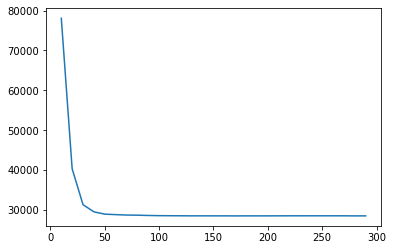

In [ ]:
train = []
test = []
option = np.arange(10,300,10)
overfit = []
for i in option:
    params = {"max_depth":5,"seed":1412,"eta":0.1, "nthread":16
             }
    result = xgb.cv(params,data_xgb,num_boost_round=i
                ,nfold=5 #补充交叉验证中所需的参数，nfold=5表示5折交叉验证
                ,seed=1412 #交叉验证的随机数种子，params中的是管理boosting过程的随机数种子
               )
    overfit.append(overfitcheck(result))
    train.append(result.iloc[-1,0])
    test.append(result.iloc[-1,2])
plt.plot(option,test);

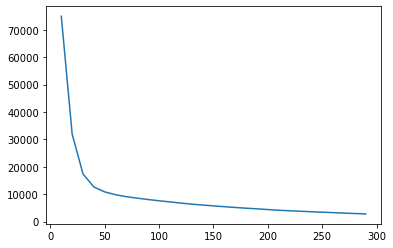

In [ ]:
plt.plot(option,train);

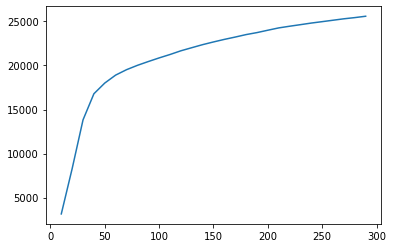

In [ ]:
plt.plot(option,overfit);

可以看到，`num_boost_round`大约增长到50左右就不再对模型有显著影响了，我们可以进一步来查看分数到30000以下之后的情况：

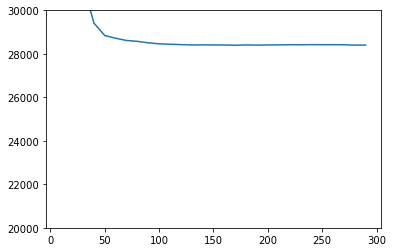

In [ ]:
plt.plot(option,test)
plt.ylim(20000,30000);

100棵树之后损失几乎没有再下降，因此`num_boost_round`的范围可以定到range(50,200,10)。

- **min_child_weight**

作为$h_i$值之和，`min_child_weight`的真实值是可以计算出来的，但精确的计算需要跟随xgboost建树的过程运行，因此比较麻烦。遗憾的是，xgboost官方并未提供调用树结构以及$h_i$值的接口，因此最佳方案其实是对每个叶子上的样本量进行估计。

In [ ]:
X.shape

(1460, 80)

现在总共有样本1460个，在五折交叉验证中训练集共有1460\*0.8 = 1168个样本。由于CART树是二叉树，我们规定的最大深度为5，因此最多有$2^5 = 32$个叶子节点，平均每个叶子结点上的样本量大概为1168/32 = 36.5个。粗略估计，如果`min_child_weight`是一个小于36.5的值，就可能对模型造成巨大影响。当然，不排除有大量样本集中在一片叶子上的情况，因此我们可以设置备选范围稍微放大，例如设置为[0,100]来观察模型的结果。

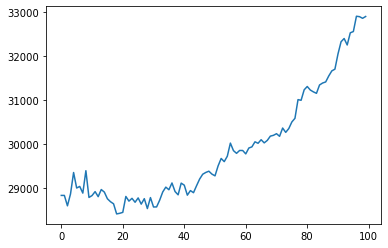

In [ ]:
train = []
test = []
option = np.arange(0,100,1)
overfit = []
for i in option:
    params = {"max_depth":5,"seed":1412,"eta":0.1, "nthread":16
              ,"min_child_weight":i
             }
    result = xgb.cv(params,data_xgb,num_boost_round=50
                ,nfold=5 #补充交叉验证中所需的参数，nfold=5表示5折交叉验证
                ,seed=1412 #交叉验证的随机数种子，params中的是管理boosting过程的随机数种子
               )
    overfit.append(overfitcheck(result))
    train.append(result.iloc[-1,0])
    test.append(result.iloc[-1,2])
plt.plot(option,test);

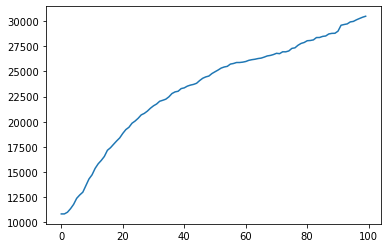

In [ ]:
plt.plot(option,train);

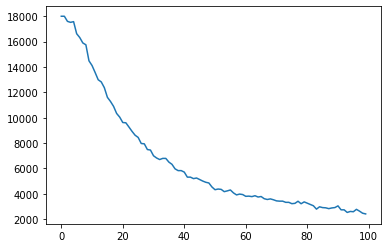

In [ ]:
plt.plot(option,overfit);

很明显，`min_child_weight`在0~40的范围之内对测试集上的交叉验证损失有较好的抑制作用，因此我们可以将`min_child_weight`的调参空间设置为range(0,50,2)来进行调参。

如此，全部参数的参数空间就确定了，如下所示：

|参数|范围|
|:-:|:-:|
|`num_boost_round`|学习曲线探索，最后定为<br>(50,200,10)|
|`eta`|以0.3为中心向两边延展，最后定为<br>(0.05,2.05,0.05)|
|`booster`|两种选项<br>["gbtree","dart"]|
|`colsample_bytree`|设置为(0,1]之间的值，但由于还有参数`bynode`，因此整体不宜定得太小，因此定为<br>(0.3,1,0.1)|
|`colsample_bynode`|设置为(0,1]之间的值，定为<br>(0.1,1,0.1)|
|`gamma`|学习曲线探索，有较大可能需要改变，定为<br>(1e6,1e7,1e6)|
|`lambda`|学习曲线探索，定为<br>(0,3,0.2)|
|`min_child_weight`|学习曲线探索，定为<br>(0,50,2)|
|`max_depth`|以6为中心向两边延展，右侧范围定得更大<br>(2,30,2)|
|`subsample`|设置为(0,1]之间的值，定为<br>(0.1,1,0.1)|
|`objective`|两种回归类模型的评估指标<br>["reg:squarederror", "reg:squaredlogerror"]|
|`rate_drop`|如果选择"dart"树所需要补充的参数，设置为(0,1]之间的值<br>(0.1,1,0.1)|

一般在初次搜索时，我们会设置范围较大、较为稀疏的参数空间，然后在多次搜索中逐渐缩小范围、降低参数空间的维度。不过这一次设置的参数空间都较为密集，参数也较多，大家在实际进行设置的时候可以选择与我设置的不同的范围或密度。

## 2 基于TEP对XGBoost进行优化

In [ ]:
#日常使用库与算法
import pandas as pd
import numpy as np
import sklearn
import matplotlib as mlp
import matplotlib.pyplot as plt
import time
import xgboost as xgb

#导入优化算法
import hyperopt
from hyperopt import hp, fmin, tpe, Trials, partial
from hyperopt.early_stop import no_progress_loss

In [ ]:
data = pd.read_csv(r"D:\Pythonwork\2021ML\PART 2 Ensembles\datasets\House Price\train_encode.csv",index_col=0)

In [ ]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [ ]:
X.shape

(1460, 80)

> Step 1.建立benchmark

|算法|RF<br>(TPE)|AdaBoost<br>(TPE)|GBDT<br>(TPE)|
|:-:|:-:|:-:|:-:|
|5折验证<br>运行时间|0.22s|0.27s|<font color="brown">**1.54s(↑)**</font>|
|测试最优分数<br>(RMSE)|28346.673|35169.730|<font color="green">**26415.835(↓)**</font>|

> Step 2.定义目标函数、参数空间、优化函数、验证函数
>> 目标函数

In [ ]:
def hyperopt_objective(params):
    paramsforxgb = {"eta":params["eta"]
                    ,"booster":params["booster"]
                    ,"colsample_bytree":params["colsample_bytree"]
                    ,"colsample_bynode":params["colsample_bynode"]
                    ,"gamma":params["gamma"]
                    ,"lambda":params["lambda"]
                    ,"min_child_weight":params["min_child_weight"]
                    ,"max_depth":int(params["max_depth"])
                    ,"subsample":params["subsample"]
                    ,"objective":params["objective"]
                    ,"rate_drop":params["rate_drop"]
                    ,"nthread":14
                    ,"verbosity":0
                    ,"seed":1412}
    result = xgb.cv(params,data_xgb, seed=1412, metrics=("rmse")
                    ,num_boost_round=int(params["num_boost_round"]))
    return result.iloc[-1,2]

>> 参数空间

In [ ]:
param_grid_simple = {'num_boost_round': hp.quniform("num_boost_round",50,200,10)
                     ,"eta": hp.quniform("eta",0.05,2.05,0.05)
                     ,"booster":hp.choice("booster",["gbtree","dart"])
                     ,"colsample_bytree":hp.quniform("colsample_bytree",0.3,1,0.1)
                     ,"colsample_bynode":hp.quniform("colsample_bynode",0.1,1,0.1)
                     ,"gamma":hp.quniform("gamma",1e6,1e7,1e6)
                     ,"lambda":hp.quniform("lambda",0,3,0.2)
                     ,"min_child_weight":hp.quniform("min_child_weight",0,50,2)
                     ,"max_depth":hp.choice("max_depth",[*range(2,30,2)])
                     ,"subsample":hp.quniform("subsample",0.1,1,0.1)
                     ,"objective":hp.choice("objective",["reg:squarederror","reg:squaredlogerror"])
                     ,"rate_drop":hp.quniform("rate_drop",0.1,1,0.1)
                    }

>> 优化函数

In [ ]:
def param_hyperopt(max_evals=100):
    
    #保存迭代过程
    trials = Trials()
    
    #设置提前停止
    early_stop_fn = no_progress_loss(30)
    
    #定义代理模型
    params_best = fmin(hyperopt_objective
                       , space = param_grid_simple
                       , algo = tpe.suggest
                       , max_evals = max_evals
                       , verbose=True
                       , trials = trials
                       , early_stop_fn = early_stop_fn
                      )
    
    #打印最优参数，fmin会自动打印最佳分数
    print("\n","\n","best params: ", params_best,
          "\n")
    return params_best, trials

> Step 3.训练贝叶斯优化器

XGBoost中涉及到前所未有多的随机性，因此模型可能表现得极度不稳定，我们需要多尝试几次贝叶斯优化来观察模型的稳定性。因此在这里我们完成了5次贝叶斯优化，查看如下的结果：

In [ ]:
params_best, trials = param_hyperopt(100) #由于参数空间巨大，给与100次迭代的空间

 38%|██████████████████▏                             | 38/100 [05:16<08:36,  8.33s/trial, best loss: 26753.27408833333]

 
 best params:  {'booster': 1, 'colsample_bynode': 0.8, 'colsample_bytree': 0.8, 'eta': 1.55, 'gamma': 2000000.0, 'lambda': 0.2, 'max_depth': 2, 'min_child_weight': 0.0, 'num_boost_round': 200.0, 'objective': 0, 'rate_drop': 0.2, 'subsample': 0.9} 



在迭代的早期就因提前停止而停下了，修改提前停止的容忍次数为30次，继续尝试：

In [ ]:
params_best, trials = param_hyperopt(100)

 57%|██████████████████████████▊                    | 57/100 [05:43<04:18,  6.02s/trial, best loss: 26775.553385333333]

 
 best params:  {'booster': 1, 'colsample_bynode': 0.5, 'colsample_bytree': 1.0, 'eta': 0.5, 'gamma': 10000000.0, 'lambda': 1.6, 'max_depth': 2, 'min_child_weight': 0.0, 'num_boost_round': 110.0, 'objective': 0, 'rate_drop': 0.1, 'subsample': 0.7000000000000001} 



In [ ]:
params_best, trials = param_hyperopt(100)

 41%|███████████████████▎                           | 41/100 [02:07<03:03,  3.11s/trial, best loss: 27363.138020666665]

 
 best params:  {'booster': 0, 'colsample_bynode': 1.0, 'colsample_bytree': 0.5, 'eta': 0.05, 'gamma': 7000000.0, 'lambda': 2.4000000000000004, 'max_depth': 9, 'min_child_weight': 0.0, 'num_boost_round': 170.0, 'objective': 0, 'rate_drop': 0.7000000000000001, 'subsample': 0.6000000000000001} 



In [ ]:
params_best, trials = param_hyperopt(100)

 52%|████████████████████████▍                      | 52/100 [05:26<05:01,  6.29s/trial, best loss: 27745.835937666667]

 
 best params:  {'booster': 1, 'colsample_bynode': 0.30000000000000004, 'colsample_bytree': 1.0, 'eta': 2.0, 'gamma': 7000000.0, 'lambda': 0.0, 'max_depth': 8, 'min_child_weight': 2.0, 'num_boost_round': 110.0, 'objective': 0, 'rate_drop': 0.4, 'subsample': 0.7000000000000001} 



In [ ]:
params_best, trials = param_hyperopt(100)

 32%|███████████████                                | 32/100 [05:21<11:23, 10.05s/trial, best loss: 26803.143880333333]

 
 best params:  {'booster': 1, 'colsample_bynode': 0.9, 'colsample_bytree': 0.4, 'eta': 1.3, 'gamma': 9000000.0, 'lambda': 1.2000000000000002, 'max_depth': 8, 'min_child_weight': 4.0, 'num_boost_round': 180.0, 'objective': 0, 'rate_drop': 0.1, 'subsample': 1.0} 



这个结果差强人意，比起GBDT跑出的最佳分数还有距离，但我们可以在此基础上继续调整参数空间。以下是5次调参的结果总结：

||1|2|3|4|5|
|:-:|:-:|:-:|:-:|:-:|:-:|
|num_boost_round|200|110|170|110|180|
|booster|1|1|0|1|1|
|objective|0|0|0|0|0|
|colsample_bynode|0.8|0.5|1.0|0.3|0.9|
|colsample_bytree|0.8|1.0|0.5|1.0|0.4|
|eta|1.55|0.5|0.05|1.0|1.3|
|gamma|2e6|1e7|7e6|7e6|9e6|
|lambda|0.2|1.6|2.4|0|1.2|
|max_depth|2|2|9|8|8|
|min_child_weight|0|0|0|2|4|
|rate_drop|0.2|0.7|0.7|0.4|0.1|
|subsample|0.9|0.7|0.6|0.7|1|

首先，`objective`在所有迭代中都被选为"reg:squarederror"，这也是xgboost的默认值，因此不再对该参数进行搜索。同样的。`booster`参数在5次运行中有4次被选为"dart"，因此基本可以确认对目前的数据使用DART树是更好的选择。同时在参考结果时我们就可以不太考虑第三次搜索的结果，因为第三次搜索是给予普通gbtree给出的结果。

对于其他参数，我们则根据搜索结果**修改空间范围、增加空间密度**，一般让范围向选中更多的一边倾斜，并且减小步长。例如`num_boost_round`从来没有选到100以下的值，还有一次触顶，两次接近上限，因此可以将原本的范围(50,200,10)修改为(100,300,10)。`colsample_bynode`的结果均匀地分布在0.3~1之间，可以考虑不更换范围，但缩小步长。`colsample_bytree`的结果更多偏向于1.0，因此可以考虑提升下限。其他的参数也以此类推：

In [ ]:
param_grid_simple = {'num_boost_round': hp.quniform("num_boost_round",100,300,10)
                     ,"eta": hp.quniform("eta",0.05,2.05,0.05)
                     ,"colsample_bytree":hp.quniform("colsample_bytree",0.5,1,0.05)
                     ,"colsample_bynode":hp.quniform("colsample_bynode",0.3,1,0.05)
                     ,"gamma":hp.quniform("gamma",5e6,1.5e7,5e5)
                     ,"lambda":hp.quniform("lambda",0,2,0.1)
                     ,"min_child_weight":hp.quniform("min_child_weight",0,10,0.5)
                     ,"max_depth":hp.choice("max_depth",[*range(2,15,1)])
                     ,"subsample":hp.quniform("subsample",0.5,1,0.05)
                     ,"rate_drop":hp.quniform("rate_drop",0.1,1,0.05)
                    }

In [ ]:
def hyperopt_objective(params):
    paramsforxgb = {"eta":params["eta"]
                    ,"colsample_bytree":params["colsample_bytree"]
                    ,"colsample_bynode":params["colsample_bynode"]
                    ,"gamma":params["gamma"]
                    ,"lambda":params["lambda"]
                    ,"min_child_weight":params["min_child_weight"]
                    ,"max_depth":int(params["max_depth"])
                    ,"subsample":params["subsample"]
                    ,"rate_drop":params["rate_drop"]
                    ,"booster":"dart"
                    ,"nthred":14
                    ,"verbosity":0
                    ,"seed":1412}
    result = xgb.cv(params,data_xgb, seed=1412, metrics=("rmse")
                    ,num_boost_round=int(params["num_boost_round"]))
    return result.iloc[-1,2]

> Step 4.在修改后的参数空间上，继续训练贝叶斯优化器

In [ ]:
params_best, trials = param_hyperopt(100) #提前停止的容忍次数提高为50次

 29%|█████████████▉                                  | 29/100 [00:53<02:00,  1.69s/trial, best loss: 27279.83528666667]

D:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



100%|██████████████████████████████████████████████| 100/100 [02:33<00:00,  1.53s/trial, best loss: 25662.024739666667]

 
 best params:  {'colsample_bynode': 0.45, 'colsample_bytree': 1.0, 'eta': 0.05, 'gamma': 13000000.0, 'lambda': 0.5, 'max_depth': 6, 'min_child_weight': 0.5, 'num_boost_round': 150.0, 'rate_drop': 0.65, 'subsample': 0.8500000000000001} 



In [ ]:
params_best, trials = param_hyperopt(100)

100%|██████████████████████████████████████████████| 100/100 [02:38<00:00,  1.59s/trial, best loss: 25711.822916666668]

 
 best params:  {'colsample_bynode': 0.7000000000000001, 'colsample_bytree': 0.75, 'eta': 0.1, 'gamma': 13500000.0, 'lambda': 1.8, 'max_depth': 3, 'min_child_weight': 1.5, 'num_boost_round': 210.0, 'rate_drop': 0.7000000000000001, 'subsample': 1.0} 



In [ ]:
params_best, trials = param_hyperopt(100)

 58%|███████████████████████████▎                   | 58/100 [01:33<01:07,  1.62s/trial, best loss: 25737.109375333337]

 
 best params:  {'colsample_bynode': 0.7000000000000001, 'colsample_bytree': 0.9500000000000001, 'eta': 0.05, 'gamma': 8000000.0, 'lambda': 0.8, 'max_depth': 9, 'min_child_weight': 1.0, 'num_boost_round': 160.0, 'rate_drop': 0.30000000000000004, 'subsample': 0.8} 



In [ ]:
params_best, trials = param_hyperopt(100)

 33%|███████████████▌                               | 33/100 [01:01<02:04,  1.85s/trial, best loss: 26307.809244666667]

 
 best params:  {'colsample_bynode': 0.7000000000000001, 'colsample_bytree': 0.7000000000000001, 'eta': 0.05, 'gamma': 8000000.0, 'lambda': 1.8, 'max_depth': 3, 'min_child_weight': 1.5, 'num_boost_round': 270.0, 'rate_drop': 0.6000000000000001, 'subsample': 0.8500000000000001} 



In [ ]:
params_best, trials = param_hyperopt(100)

100%|████████████████████████████████████████████████████| 100/100 [02:49<00:00,  1.69s/trial, best loss: 26049.842448]

 
 best params:  {'colsample_bynode': 0.5, 'colsample_bytree': 0.65, 'eta': 0.05, 'gamma': 12500000.0, 'lambda': 0.2, 'max_depth': 4, 'min_child_weight': 1.0, 'num_boost_round': 220.0, 'rate_drop': 0.5, 'subsample': 0.55} 



我们在经过调整后的参数空间上进行了5次搜索，其中得到的最糟糕的成绩是26307.809，但这已经是一个超越GBDT的分数。在5次搜索当中，我们得到的最佳分数是25662.024。现在我们可以尝试在验证函数上验证这一组参数：

> Step 5.验证参数
>> 验证函数

In [ ]:
def hyperopt_validation(params):
    paramsforxgb = {"eta":params["eta"]
                    ,"booster":"dart"
                    ,"colsample_bytree":params["colsample_bytree"]
                    ,"colsample_bynode":params["colsample_bynode"]
                    ,"gamma":params["gamma"]
                    ,"lambda":params["lambda"]
                    ,"min_child_weight":params["min_child_weight"]
                    ,"max_depth":int(params["max_depth"])
                    ,"subsample":params["subsample"]
                    ,"rate_drop":params["rate_drop"]
                    ,"nthred":14
                    ,"verbosity":0
                    ,"seed":1412}
    result = xgb.cv(params,data_xgb, seed=1412, metrics=("rmse")
                    ,num_boost_round=int(params["num_boost_round"]))
    return result.iloc[-1,2]

In [ ]:
bestparams = {'colsample_bynode': 0.45
               , 'colsample_bytree': 1.0
               , 'eta': 0.05
               , 'gamma': 13000000.0
               , 'lambda': 0.5
               , 'max_depth': 6
               , 'min_child_weight': 0.5
               , 'num_boost_round': 150.0
               , 'rate_drop': 0.65
               , 'subsample': 0.8500000000000001} 

In [ ]:
start = time.time()
hyperopt_validation(bestparams)

25368.487630333333

In [ ]:
end = (time.time() - start)
print(end)

1.1478571891784668


|算法|RF<br>(TPE)|AdaBoost<br>(TPE)|GBDT<br>(TPE)|XGB<br>(TPE)|
|:-:|:-:|:-:|:-:|:-:|
|5折验证<br>运行时间|0.22s|0.27s|1.54s(↑)|<font color="green">**1.14s(↓)**</font>|
|测试最优分数<br>(RMSE)|28346.673|35169.730|26415.835(↓)|<font color="green">**25368.487(↓)**</font>|

从参数的密度来看，我们还可以继续提升我们的分数，但课时有限，我们就不再继续调整了，大家可以顺着相似的思路继续往下调整，查看XGBoost是否还有更大的空间。

# 四 原理进阶：XGBoost的求解流程

**<font color="red">学习XGBoost的数学原理需要大量梯度提升树（GBDT）相关知识，本课程将假设你已经非常熟悉梯度提升树的原理与特点。如果你不熟悉梯度提升树，强烈建议你回顾之前的课程。</font>**

## 1 XGBoost的基本数学流程

作为Boosting算法的里程碑，XGBoost以它高度复杂的数学原理闻名。无论你是阅读XGBoost原始论文，还是寻找经典书籍作为资料，都会发现数学占了很大的篇幅。然而事实上，随着Boosting算法的数学过程越来越复杂，实际建模过程和实现代码却是越来越简单的。**数学并没有让算法变得更复杂，而是让算法变得更简单**。

- **参考文献**

XGBoost最初是由陈天奇及华盛顿大学团队在2014年提出，在提出时就已经具有了今天我们要证明的全套复杂数学理论。但在搭建xgboost算法库的过程中，研发团队不断吸收当代各种经典算法的元素，形成更加复杂的算法系统：例如，DART树是吸收了深度学习中的Dropout技术，我们没有详细讲解的基于直方图的估计贪婪算法是借鉴LightGBM的技术，参考以下论文：

《XGBoost：一种可拓展的提升树系统》
Chen,T.Q.; Geustrin, C. (2014). "XGBoost: A Scalable Tree Boosting System"

《DART树：当Dropout遇见自适应回归树》
Rashmi, K.V.; Ran Gilad-Bachrach.(2015) “DART: Dropouts meet Multiple Additive Regression Trees”

《Lightgbm：一种极度高效的梯度提升树》
Ke, G. et al.(2017)."Lightgbm: A highly efficient gradient boosting decision tree"

你可以在本周上传的课程中找到以上三篇论文。需要注意的是，在本节中我们将会专注于最原始的XGBoost论文，而不会涉及到其他两篇文献的内容。其中，XGBoost基本数学流程是总结自GBDT的流程与XGBoost论文中涉及到的伪代码，而所有证明过程都来自于XGBoost原始论文。同时，为了与之前的课程保持一致，我们将使用与原论文略有不同的符号，但数学过程将是完全相同的。在阅读原论文时，记得辨析不同的数学符号。

- **基本流程**

不要忘记，对任何Boosting算法来说我们都有如下流程（对大部分算法来说是损失函数$L$，对XGBoost来说是目标函数$O$）：

---
**<font color="green"><center>依据上一个弱评估器$f(x)_{k-1}$的结果，计算目标函数$O$，
    <br>并使用$O$自适应地影响下一个弱评估器$f(x)_k$的构建。<br>集成模型输出的结果，受到整体所有弱评估器$f(x)_0$ ~ $f(x)_K$的影响。</center></font>**
---

假设现有数据集$N$，含有形如$(x_i,y_i)$的样本$M$个，$i$为任意样本的编号，单一样本的损失函数为$l(y_i,H(x_i))$，其中$H(x_i)$是$i$号样本在集成算法上的预测结果，整个算法的损失函数为$L(y,H(x))$，且总损失等于全部样本的损失之和：$L(y,H(x)) = \sum_i l(y_i,H(x_i))$。目标函数中使用L2正则化（$\lambda$为0，$\alpha$为0），并且$\gamma$不为0。

同时，弱评估器为回归树$f$，总共学习$K$轮（注意在GBDT当中我们使用的是大写字母T来表示迭代次数，由于在XGBoost当中字母T被用于表示目标函数中的叶子总量，因此我们在这里使用字母K表示迭代次数）。则XGBoost回归的基本流程如下所示：

- **1) 初始化**

初始化数据迭代的起点$H_0(x)$。在应用xgboost时，我们可以指定任意数字来作为$H_0(x)$，但在xgboost原始论文当中，并未详细讨论如何计算迭代的初始值。考虑到XGBoost在许多方面继承了梯度提升树GBDT的思想，我们可以使用公式来计算XGBoost的$H_0$：

$$
\begin{aligned}
H_0(x) &= \mathop{argmin}_{C} \sum_{i=1}^M l(y_i,C)\\ \\
&= \mathop{argmin}_{C} L(y,C)
\end{aligned}
$$

其中$y_i$为真实标签，$C$为任意常数。以上式子表示，找出令$\sum_{i=1}^Ml(y_i,C)$最小的常数$C$值，并输出最小的$\sum_{i=1}^Ml(y_i,C)$作为$H_0(x)$的值。需要注意的是，由于$H_0(x)$是由全部样本的$l$计算出来的，因此所有样本的初始值都是$H_0(x)$，不存在针对某一样本的单一初始值。

由于在初始的时候没有树结构，因此没有复杂度等信息，因此没有使用目标函数求初始值，而是使用了损失函数。在GBDT的数学过程当中，我们详细展示过如何求解令初始损失最小的$C$（对损失求一阶导数并让一阶导数为0），并且我们详细证明过，当损失函数为MSE时，令整体初始损失最小的$C$值就是$y$的均值。对XGBoost来说这一切都成立，只不过在xgboost库中我们默认的初始值为0.5。
<br>

开始循环，for k in 1,2,3...K:

> - **2) 抽样**<br><br>
在现有数据集$N$中，抽样$M$ * `subsample`个样本，构成训练集$N^k$<br><br>
> - **3) 求拟合项**<br><br>
对任意一个样本$i$，计算一阶导数$g_{ik}$，二阶导数$h_{ik}$，以及伪残差（pseudo-residuals）$r_{ik}$，具体公式为：<br><br>
> $$g_{ik} = \frac{\partial{l(y_i,H_{k-1}(x_i))}}{\partial{H_{k-1}(x_i)}}$$<br>
> $$h_{ik} = \frac{\partial^2{l(y_i,H_{k-1}(x_i))}}{\partial{H^2_{k-1}(x_i)}}$$<br>
> $$r_{ik} = -\frac{g_{ik}}{h_{ik}}$$

> 不难发现，伪残差是一个样本的一阶导数除以二阶导数并取负的结果，并且在进行第k次迭代、计算第k个导数时，我们使用的是前k-1次迭代后输出的集成算法结果。同时，我们是先对目标函数$l$中的自变量$H(x)$求导，再令求导后的结果等于$H_{t-1}(x_i)$的值，并不是直接对$H_{t-1}(x_i)$这一常数求导。<br><br>
> 对常数求导，以及对变量求导是两个概念，举例说明：<br><br>
> $$l = x^2+x$$
> 对常数0求导：$$\frac{\partial{l}}{\partial{0}} = \frac{\partial{(x^2 + x)}}{0} = 0$$<br>
> 对变量x求导并让x=0：$$\frac{\partial{l}}{\partial{x}} = \frac{\partial{(x^2 + x)}}{\partial x} = 2x + 1 = 2*0 + 1 = 1$$<br>
> 因此，$g_{ik}$标准的写法应该是：
> $$g_{ik} = \big[\frac{\partial{l(y_i,H(x_i))}}{\partial{H(x_i)}}\big]_{H(x_i) = H_{k-1}\ \ (x_i)}$$<br>
> 在实际推导过程中，为公式简洁，简写为上述流程中的写法。<br><br>
> 在k=1时，所有求导计算过程中的$H_{k-1}(x_i)$都等于初始$H_0(x)$，在k>1时，每个样本上的$H_{k-1}(x_i)$都是不同的取值。<br>

> - **4) 建树**<br><br>
求解出伪残差后，在数据集$(x_i, r_{ik})$上按`colsample_by*`规则进行抽样，再按照**结构分数增益**规则建立一棵回归树$f_k$。注意在这个过程中，训练时拟合的标签为样本的伪残差$r_{ik}$，并且叶子节点$j$的结构分数和任意分枝时的结构分数增益的公式为：<br><br>
>$$Score_j = \frac{(\sum_{i \in j}g_i)^2}{\sum_{i \in j}h_i + \lambda}$$<br>
>$$Gain = \frac{1}{2} \left( \frac{(\sum_{i \in L}g_i)^2}{\sum_{i \in L}h_i + \lambda} + \frac{(\sum_{i \in R}g_i)^2}{\sum_{i \in R}h_i + \lambda} - \frac{(\sum_{i \in P}g_i)^2}{\sum_{i \in P}h_i + \lambda} \right) - \gamma$$ <br>
>建树过程不影响任何$g_{ik}$与$h_{ik}$的值。<br><br>
> - **5) 输出树上的结果**<br><br>
建树之后，依据回归树$f_k$的结构输出叶子节点上的输出值（预测值）。对任意叶子节点$j$来说，输出值为：<br><br>
> $$w_j = -\frac{\sum_{i \in j}g_{ik}}{\sum_{i \in j}h_{ik} + \lambda}$$<br>
> 假设样本$i$被分割到叶子$j$上，则有：<br><br>
> $$f_k(x_i) = w_j$$

> 使用字母$w$表示叶子节点上的输出值是XGBoost论文所规定的，我们曾经见过一次$w$，你还记得在哪里吗？在我们介绍XGBoost的目标函数时，L2正则项的表达式为$\frac{1}{2} \lambda \sum_{j=1}^T w_j^2$。我们曾说过$w$代表XGBoost中的叶子权重，**实际上叶子权重就是叶子上的输出值**。为不和其他权重混淆，之后我们统一称呼$w$为输出值。<br><br>
>不难发现，叶子节点上的输出值与结构分数很相似，只不过结构分数的分子上是平方，而输出值的分子上没有平方。在数学上我们可以证明，**该输出值能让目标函数最快减小**。<br><br>
> 你可能注意到了，在迭代刚开始时我们已经知道了输出值式子中所需的所有$g$和$h$。为什么还要建树呢？只有当我们建立了决策树，我们才能够知道具体哪些样本$i$在叶子节点$j$上。因此树$f_k$提供的是结构信息。<br><br>
> 由于任意样本必然被分到任意叶子上，因此对整棵树$f_k$来说，任意$f_k(x_i)$一定有对应的$w$。<br>

> - **6) 迭代**<br><br>
根据预测结果$f_k(x_i)$迭代模型，具体来说：<br><br>
> $$H_k(x_i) = H_{k-1}(x_i) + f_k(x_i)$$<br>
> 假设输入的步长为$\eta$，则$H_k(x)$应该为：<br><br>
> $$H_k(x_i) = H_{k-1}(x_i) + \eta f_k(x_i)$$<br>
> 对整个算法则有：<br><br>
> $$H_k(x) = H_{k-1}(x) + \eta f_k(x)$$<br>

- **7) 循环结束**<br><br>输出$H_K(x)$的值作为集成模型的输出值。

以上就是XGBoost的完整数学流程。不难发现，作为从GBDT改进而来的算法，XGBoost在基础数学流程上基本继承了GBDT的流程（7步走的流程与GBDT一模一样，同时也有继承伪残差等细节），但又在具体每个流程中都做出了改进，进一步简化了Boosting算法的运算流程——比如说，虽然整个算法持续再向降低目标函数的方向运行，但整个过程中不存在任何的**求最优解**的数学计算。除了建树流程以外，其他流程都是非常简单的按公式计算而已。

由于XGBoost原始论文中并不存在上述流程的完整说明，因此要梳理出该流程并不容易，但如果我们对GBDT的流程相对熟悉，那XGBoost的流程也并不难。对XGBoost来说，真正难度较大的部分并不是梳理以上算法流程，而是证明这一流程可以让模型向着目标函数最小化的方向运行。在这个流程中包括如下很明显的问题：

- 1. 建树时拟合的$r_{ik} = -\frac{g_{ik}}{h_{ik}}$究竟是什么？拟合它有什么意义？

- 2. 结构分数和结构分数增益的公式是如何推导出来的？为什么这样建树可以提升模型的效果？

- 3. 为什么叶子节点的输出值$w_j$是$-\frac{(\sum_{i \in j} g_{ik})}{\sum_{i \in j} h_{ik} + \lambda}$？这样输出有什么意义？

- 4. 课程的第一部分说XGBoost拟合的也是残差，残差在哪里？

接下来我们就将展示完整的证明来回答这些问题。

## 2 化简XGBoost的目标函数

- **定义目标函数与目标函数的自变量**

首先，根据之前对目标函数的定义，**XGBoost中目标函数是针对一棵树的目标函数**，而不是针对一个样本或一整个算法的目标函数。并且，任意树的目标函数都包括三大部分：损失函数$l$、叶子数量$T$以及正则项。具体地来说：

假设单一树$f_k$的目标函数为$O_k$，总共有$T$片叶子，该树上任意样本$i$的损失函数为$l((y_i,H(x_i))$，其中$H(x_i)$是$i$号样本在集成算法上的预测结果。树上总共有M个样本，目标函数中使用L2正则化（$\lambda$不为0，$\alpha$为0），并且$\gamma$不为0，则该树的目标函数为：

$$O_k = \sum_{i=1}^Ml(y_i,H_k(x_i)) + \gamma T + \frac{1}{2}\lambda\sum_{j=1}^Tw_j^2$$

**我们的目标是令目标函数最小，并找出令目标函数最小的某个自变量**。对使用普通损失函数的Boosting算法来说，算法的输出值$H(x)$是在迭代过程中不断变化的，损失函数$l(y,H(x))$也是在迭代中不断变小的：

$$H_k(x_i) = H_{k-1}(x_i) + f_k(x_i)$$

$$l_k = l(y_i,H_{k-1}(x_i) + f_k(x_i))$$

当迭代到第$k$次时，损失函数中的$y_i$与$H_{k-1}(x_i)$都是常数，只有$f_k(x_i)$是变量，因此我们只需要在损失函数上对$f_k(x_i)$求导，并找到令整体损失函数最小的预测值$f_k(x_i)$即可。在GBDT当中，我们提到过，**无论弱评估器$f_k$是什么结构、什么规则、如何建立、如何拟合，只要其最终的输出值$f_k(x_i)$是令整体损失函数$L$最小化的$f_k(x_i)$，那随着算法逐步迭代，损失函数必然会越来越小**。因此，一个适合的$f_k(x_i)$不仅能保证损失持续减小，还可以指导单个评估器的建立。

在GBDT当中，我们证明了令GBDT整体损失函数最小化的$f_k(x_i)$就是损失函数的负梯度$-g_i$（详见GBDT课程《四 4：证明：拟合伪残差可以令损失函数最快地减小》），也因此GBDT在建树时拟合负梯度。当损失函数为$\frac{1}{2}MSE$时，GBDT中的负梯度在数值上就等于残差，因此GBDT是拟合残差的算法。

在XGBoost当中，我们也可以对目标函数求导、并找出令目标函数最小的某个自变量，但问题在于，XGBoost的目标函数中存在多个自变量：

$$\begin{aligned} O_k &= \sum_{i=1}^Ml(y_i,H_k(x_i)) + \gamma T + \frac{1}{2}\lambda\sum_{j=1}^Tw_j^2 \\ &= \sum_{i=1}^M l \left( y_i,H_{k-1}(x_i) + \boldsymbol{\color{red}{f_k(x_i)}} \right) + \gamma \boldsymbol{\color{red}T} + \frac{1}{2}\lambda\sum_{j=1}^T\boldsymbol{\color{red}{w_j}}^2 \end{aligned}$$

其中，$T$是第$k$棵树上的叶子总量，$f_k(x_i)$与$w_j$都是模型输出的预测值（叶子上的输出值），不过表现形式不同，对任意位于叶子$j$上的样本$i$而言，数值上$f_k(x_i) = w_j$。对XGBoost来说，只能选择一个变量作为自变量，**考虑到$f_k(x_i)$只与单个样本的精确程度有关，而$T$只与树结构有关，XGBoost论文最终选择了即与精确度有关、又与树结构有关的变量**$w_j$。同时，如果知道叶子的最佳输出值$w_j$就可以引导树成长为合理的结构，但只知道叶子的总量$T$是无法指导建树的。

因此，求解XGBoost目标函数的第一步，就是将目标函数尽量整理成以$w_j$表示的形式。

- **对目标函数进行泰勒展开**

在GBDT当中，我们借助一阶泰勒展开化简了损失函数，借鉴于GBDT的思路，XGBoost也使用了泰勒展开。具体来看：

在数学中，泰勒级数使用无限个项的连加式来表示一个函数。实际应用当中，我们一般取有限项的连加式来逼近一个函数。当总共有N项时，连加式被叫做N阶泰勒展开（Nth-order Taylor approximation）。假设现在存在函数$f(x)$，则有：

> - **泰勒级数（无限项）**： 
$$f(x) = \sum_{n=0}^{\infty}\frac{f^{(n)}(a)}{n!}(x-a)^n$$

其中(x-a)是非常小的任意实数/复数，$n!$是n的阶乘，$f^{(n)}(a)$是函数$f(x)$的n阶导数在a点的取值。当a为0时，泰勒级数也被叫做麦克劳思级数。

> - **一阶泰勒展开**：
$$\begin{aligned}
f(x) &\approx \sum_{n=0}^{1}\frac{f^{(n)}(a)}{n!}(x-a)^n \\
&\approx f(a) + \frac{f'(a)}{1!}(x-a)
\end{aligned}
$$

> - **二阶泰勒展开**：
$$\begin{aligned}
f(x) &\approx \sum_{n=0}^{2}\frac{f^{(n)}(a)}{n!}(x-a)^n \\
&\approx f(a) + \frac{f'(a)}{1!}(x-a) + \frac{f''(a)}{2!}(x-a)^2
\end{aligned}
$$

> - **N阶泰勒展开**：
$$\begin{aligned}
f(x) &\approx \sum_{n=0}^{N}\frac{f^{(n)}(a)}{n!}(x-a)^n \\
&\approx f(a) + \frac{f'(a)}{1!}(x-a) + \frac{f''(a)}{2!}(x-a)^2 + \frac{f'''(a)}{3!}(x-a)^3 + ...
\end{aligned}
$$

阶数越大，泰勒展开的值越接近$f(x)$的真实值。

在我们的目标函数$O_k$中，**可以被泰勒展开的是第一部分损失函数**$l$：

$$O_k = \sum_{i=1}^Ml \left( y_i,H_{k-1}(x_i) + f_k(x_i) \right) + \gamma T + \frac{1}{2}\lambda\sum_{j=1}^T w_j^2$$

由于损失函数$l$中只有唯一变量$H_{k-1}(x_i) + f_k(x_i)$，因此可以将函数简写为$l(H_{k-1}(x_i) + f_k(x_i))$。

根据二阶泰勒展开，已知：

$$\begin{aligned}
f(x) &\approx \sum_{n=0}^{2}\frac{f^{(n)}(a)}{n!}(x-a)^n \\
&\approx f(a) + \frac{f'(a)}{1!}(x-a) + \frac{f''(a)}{2!}(x-a)^2
\end{aligned}
$$

令泰勒展开中的$x = H_{k-1}(x_i) + f_k(x_i)$，令泰勒展开中的$a = H_{k-1}(x_i)$，则$(x-a) = f_k(x_i)$。据此，损失函数$l(H_{k-1}(x_i) + f_k(x_i))$可以被表示为：

$$\begin{aligned}
l(H_{k-1}(x_i) + f_k(x_i)) &\approx l(H_{k-1}(x_i)) + \frac{\partial{l(H_{k-1}(x_i))}}{\partial{H_{k-1}(x_i)}} * f_k(x_i) +  \frac{\partial^2{l(H_{k-1}(x_i))}}{2\partial{H^2_{k-1}(x_i)}} * f^2_k(x_i)\\
\end{aligned}
$$

在XGBoost中我们定义过损失函数的一阶导数与二阶导数：

$$g_{ik} = \frac{\partial{l(y_i,H_{k-1}(x_i))}}{\partial{H_{t-1}(x_i)}}$$

$$h_{ik} = \frac{\partial^2{l(y_i,H_{k-1}(x_i))}}{\partial{H^2_{t-1}(x_i)}}$$

**在XGBoost原论文中，为了公式简洁，$g_i$和$h_i$并没有呈现下标$k$，但我们已经很清楚：$g$与$h$是在每一轮迭代时需要被重新计算的**。在这里我们也参照原论文中的做法去掉下标$k$。因此，经过泰勒展开后的式子可以化简为：

$$\begin{aligned}l(H_{k-1}(x_i) + f_k(x_i)) &\approx l(H_{k-1}(x_i)) + g_if_k(x_i) + \frac{1}{2}h_if^2_k(x_i) \\ &\approx 常数 + g_if_k(x_i) + \frac{1}{2}h_if^2_k(x_i) \end{aligned}$$

不难发现，该式子中$H_{k-1}(x_i)$是常数，因此第一部分$l(H_{t-1}(x_i))$也是一个常数，常数无法被最小化，因此我们可以将常数从该目标函数中剔除。经过泰勒展开，目标函数变为：

$$\begin{aligned} \tilde{O}_k &= \sum_{i=1}^M\left(g_if_k(x_i) + \frac{1}{2}h_if^2_k(x_i)\right) + \gamma T + \frac{1}{2}\lambda\sum_{j=1}^T w_j^2 \\ &= \sum_{i=1}^Mg_if_k(x_i) + \frac{1}{2}\sum_{i=1}^Mh_if^2_k(x_i) + \gamma T + \frac{1}{2}\lambda\sum_{j=1}^T w_j^2\end{aligned}$$

- **统一自变量**

现在目标函数的前两项分别代表所有样本的$g_if_k(x_i)$之和，以及所有样本的$h_if^2_k(x_i)$之和乘1/2。别忘记，我们选择的唯一的自变量是$w_j$，因此我们希望能够将$f_k$以某种方式转化为$w_j$。之前已经提到过多次，对任意位于叶子$j$上的样本$i$而言，数值上$f_k(x_i) = w_j$，我们可以尝试着从一个样本开始进行转化：

对于单一样本$i$，假设这个样本位于叶子$j$上，应该有：

$$g_if_k(x_i) = g_iw_j$$

对于一片叶子$j$，我们可以计算这片叶子上所有样本的$g_iw_j$之和：

$$\sum_{i \in j} g_iw_j $$

而一片叶子上所有样本的$w_j$都是一致的，因此一片叶子上的$g_iw_j$之和可以转变为：

$$\begin{aligned}\sum_{i \in j} g_iw_j &= g_1w_j \ + \ g_2w_j \ + \ ... \ + \ g_nw_j，其中1,2...n是叶子j上的样本 \\
&= w_j\sum_{i \in j} g_i\end{aligned}$$

假设现在一共有$T$片叶子，则整棵树上所有样本的$g_iw_j$之和为：

$$\sum_{j=1}^T \left( w_j\sum_{i \in j} g_i \right)$$

所以：

$$\sum_{i=1}^Mg_if_k(x_i) = \sum_{j=1}^T \left( w_j\sum_{i \in j} g_i \right)$$

同理，单一样本$i$的$h_if^2_k(x_i)$也可以以相同方式转化。对单一样本：

$$h_if^2_k(x_i) = h_iw^2_j$$

对一片叶子：

$$\begin{aligned}\sum_{i \in j}h_iw^2_j &= h_1w^2_j \ + \ h_2w^2_j \ + \ ... \ + \ h_nw^2_j，其中1,2...n是叶子j上的样本 \\ &= w^2_j\sum_{i \in j} h_i \end{aligned}$$

对整棵树：

$$\sum_{i=1}^Mh_if^2_k(x_i) = \sum_{j=1}^T \left( w^2_j\sum_{i \in j} h_i \right)$$

因此对整个目标函数有：

$$\begin{aligned} \tilde{O}_k &= \sum_{i=1}^Mg_if_k(x_i) + \frac{1}{2}\sum_{i=1}^Mh_if^2_k(x_i) + \gamma T + \frac{1}{2}\lambda\sum_{j=1}^T w_j^2 \\ 
&=\sum_{j=1}^T \left( w_j\sum_{i \in j} g_i + \frac{1}{2}w^2_j\sum_{i \in j} h_i \right) + \gamma T + \frac{1}{2}\lambda\sum_{j=1}^T w_j^2\end{aligned}$$

不难发现，现在正则项可以与原来损失函数的部分合并了：

$$\begin{aligned}
 &= \sum_{j=1}^T \left( w_j\sum_{i \in j} g_i + \frac{1}{2}w^2_j\sum_{i \in j} h_i + \frac{1}{2}\lambda w_j^2 \right) + \gamma T \\ 
&= \sum_{j=1}^T \left( w_j\sum_{i \in j} g_i + \frac{1}{2}w^2_j(\sum_{i \in j} h_i + \lambda) \right) + \gamma T\end{aligned}$$

合并之后，整个目标函数变为两项，一项是所有叶子上的（损失+正则）之和，另一项是叶子总量。现在，我们可以开始求解最小目标函数以及对应的最优自变量$w_j$了。

## 3 求解XGBoost的目标函数

首先，令目标函数中的叶子总量最小是不可能的，过度降低叶子总量会大幅度伤害模型的学习能力，因此我们只能考虑令所有叶子上的（损失+正则）之和最小。

其次，当树建好之后，叶子与叶子之间是相互独立的，因此每片叶子上的（损失+正则）也是相互独立的。我们只要令每片叶子的（损失+正则）都最小，就可以保证全部叶子的（损失+正则）之和最小。故而，我们要令式子中标注为红色的部分最小：

$$\begin{aligned}
\tilde{O}_k 
&= \sum_{j=1}^T \left( \boldsymbol{\color{red}{w_j\sum_{i \in j} g_i + \frac{1}{2}w^2_j(\sum_{i \in j} h_i + \lambda)}} \right) + \gamma T\end{aligned}$$

- **叶子权重**$w_j$

将标注为红色的部分命名为$\mu_j$，表示叶子$j$上的损失+正则。则有：

$$\mu_j = w_j\sum_{i \in j} g_i + \frac{1}{2}w^2_j(\sum_{i \in j} h_i + \lambda)$$

**现在，对叶子$j$而言**，在$\mu_j$上对唯一自变量$w_j$求导，则有：

$$\begin{aligned}\frac{\partial{\mu_j}}{\partial w_j}
&= \frac{\partial{w_j\sum_{i \in j} g_i + \frac{1}{2}w^2_j(\sum_{i \in j} h_i + \lambda)}}{\partial w_j} \\ \\
&= \sum_{i \in j} g_i + w_j(\sum_{i \in j} h_i + \lambda)\end{aligned}$$

令一阶导数为0，则有：

$$\begin{aligned}
\sum_{i \in j} g_i + w_j(\sum_{i \in j} h_i + \lambda) &= 0 \\ \\
w_j(\sum_{i \in j} h_i + \lambda) &= -\sum_{i \in j} g_i \\ \\
w_j &= -\frac{\sum_{i \in j} g_i}{\sum_{i \in j} h_i + \lambda}\end{aligned}$$

你应该发现了，**对一片叶子来说，令目标函数最小的$w_j$就是我们之前提过的叶子权重，也就是XGBoost数学流程当中叶子上的输出值**。如果要令叶子的输出非常接近叶子权重公式，那应该如何拟合每个样本呢？

- **拟合值**

**对任意位于叶子$j$上的样本$i$来说**：

$$\mu_i = w_jg_i + \frac{1}{2}w^2_jh_i$$

将一片叶子上的$\mu_j$转变成$\mu_i$时，原则上需要将$\mu_j$中的每一项都转换为单个样本所对应的项，然而在转换正则项时则存在问题：与$\sum_{i \in j} g_i$这样可以直接指向单个样本的项不同，$\lambda$是针对与一片叶子设置的值，如果要将$\lambda$转变为针对单一样本的正则项，则需要知道当前叶子上一共有多少样本。然而，拟合发生在建树之前，因此在这一时间点不可能知道一片叶子上的样本总量，因此在xgboost的实际实现过程当中，**拟合每一片叶子时不涉及正则项**，只有在计算结构分数与叶子输出值时才使用正则项。

对$\mu_i$上唯一的自变量$w_j$求导，则有：

$$\begin{aligned}\frac{\partial{\mu_i}}{\partial w_j}
&= \frac{\partial{\left( w_jg_i + \frac{1}{2}w^2_jh_i \right)}}{\partial w_j} \\ \\
&= g_i + w_jh_i\end{aligned}$$

令一阶导数为0，则有：

$$\begin{aligned}
g_i + w_jh_i &= 0 \\ \\
w_jh_i &= - g_i \\ \\
w_j &= -\frac{g_i}{h_i} \end{aligned}$$

**对任意样本$i$而言，令目标函数最小的最优$w_j$就是我们的伪残差$r_i$，也就是XGBoost数学流程当中用于进行拟合的拟合值**。

- **结构分数**

现在，我们把令目标函数最小的最优$w_j$带回到$\mu_j$中，查看$\mu_j$如何变化：

$$\begin{aligned}
\mu_j &= w_j\sum_{i \in j} g_i + \frac{1}{2}w^2_j(\sum_{i \in j} h_i + \lambda) \\
&= -\frac{\sum_{i \in j} g_i}{\sum_{i \in j} h_i + \lambda} * \sum_{i \in j} g_i + \frac{1}{2}(-\frac{\sum_{i \in j} g_i}{\sum_{i \in j} h_i + \lambda})^2 * {\sum_{i \in j} h_i + \lambda}\\
&= -\frac{(\sum_{i \in j} g_i)^2}{\sum_{i \in j} h_i + \lambda} + \frac{1}{2}\frac{(\sum_{i \in j} g_i)^2}{\sum_{i \in j} h_i + \lambda} \\
&= - \frac{1}{2}\frac{(\sum_{i \in j} g_i)^2}{\sum_{i \in j} h_i + \lambda}
\end{aligned}$$

因此，目标函数（所有叶子上的损失）就可以变为：

$$\begin{aligned}
\tilde{O}_k 
&= \sum_{j=1}^T \left( \boldsymbol{\color{red}{w_j\sum_{i \in j} g_i + \frac{1}{2}w^2_j(\sum_{i \in j} h_i + \lambda)}} \right) + \gamma T \\ \\
&= \sum_{j=1}^T \left( -\frac{1}{2}\frac{(\sum_{i \in j} g_i)^2}{\sum_{i \in j} h_i + \lambda} \right) + \gamma T \end{aligned}
$$

因此，一片叶子上的目标函数就是：

$$ O_j = -\frac{1}{2}\frac{(\sum_{i \in j} g_i)^2}{\sum_{i \in j} h_i + \lambda} + \gamma$$

对任意一片叶子来说，目标函数可以衡量叶子的质量，其中$\gamma$是可以设定的超参数，$\frac{1}{2}$为常数，因此对任意叶子，我们希望标注为红色的部分越小越好：

$$ O_j = \frac{1}{2}\left( \boldsymbol{\color{red}{-\frac{(\sum_{i \in j} g_i)^2}{\sum_{i \in j} h_i + \lambda}}} \right)+ \gamma$$

故而，我们希望以下式子越大越好：

$$\frac{(\sum_{i \in j} g_i)^2}{\sum_{i \in j} h_i + \lambda}$$

这个式子，**正是XGBoost用于分枝时的指标“结构分数”（Structure Score）**。

- **结构分数的增益**

当分枝的时候，我们希望目标函数越小越好，因此在分枝过程中，父节点的目标函数是大于子节点的目标函数的，因此我们可以使用（父节点目标函数 - 子节点目标函数之和）来衡量分枝的质量，则有：

$$\begin{aligned}
Gain &= O_p - (O_l + O_r) \\ \\
&= -\frac{1}{2}\frac{(\sum_{i \in P} g_i)^2}{\sum_{i \in P} h_i + \lambda} + \gamma - (-\frac{1}{2}\frac{(\sum_{i \in L} g_i)^2}{\sum_{i \in L} h_i + \lambda} + \gamma  -\frac{1}{2}\frac{(\sum_{i \in R} g_i)^2}{\sum_{i \in R} h_i + \lambda} + \gamma) \\ \\
&= -\frac{1}{2}\frac{(\sum_{i \in P} g_i)^2}{\sum_{i \in P} h_i + \lambda} + \gamma + \frac{1}{2}\frac{(\sum_{i \in L} g_i)^2}{\sum_{i \in L} h_i + \lambda} - \gamma + \frac{1}{2}\frac{(\sum_{i \in R} g_i)^2}{\sum_{i \in R} h_i + \lambda} - \gamma \\ \\
&= \frac{1}{2}\left( \frac{(\sum_{i \in L} g_i)^2}{\sum_{i \in L} h_i + \lambda} + \frac{(\sum_{i \in R} g_i)^2}{\sum_{i \in R} h_i + \lambda} - \frac{(\sum_{i \in P} g_i)^2}{\sum_{i \in P} h_i + \lambda} \right) - \gamma \\ \\
&= \frac{1}{2} (Score_L + Score_R - Score_P) - \gamma
\end{aligned}$$

其中，$\gamma$是可以设定的超参数，$\frac{1}{2}$为常数，因此：

$$Gain = Score_L + Score_R - Score_P$$

**这就是我们在分枝时所使用的结构分数增益了**。

现在你发现了，XGBoost流程中所使用的全部新公式（包括独特的拟合值、独特的分枝指标、独特的输出值）都是通过令目标函数最小而求解出来的。因此，XGBoost整个流程就保证了目标函数一定是向着最小化方向进行迭代的，新生成的每片叶子上的输出值$w_j$都是会令目标函数最小化的输出值。现在，你可以回答以下的问题了：

- 1. 建树时拟合的$r_{ik} = -\frac{g_{ik}}{h_{ik}}$究竟是什么？拟合它有什么意义？

- 2. 结构分数和结构分数增益的公式是如何推导出来的？为什么这样建树可以提升模型的效果？

- 3. 为什么叶子节点的输出值$w_j$是$-\frac{(\sum_{i \in j} g_{ik})}{\sum_{i \in j} h_{ik} + \lambda}$？这样输出有什么意义？

- 4. 课程的第一部分说XGBoost拟合的也是残差，残差在哪里？

唯一余留问题4其实我们早已解答过，回去查看第二部分中的《2.2 弱评估器的分枝》，你会发现其实我们早已经求出残差了。当目标函数为$\frac{1}{2}MSE$，负梯度$-g_i$就等于残差，而$h_i = 1$，因此拟合项$-\frac{g_i}{h_i}$自然也是残差本身了。因此，XGBoost也是拟合负梯度的算法，并且在特定损失函数下，XGBoost也拟合残差。在了解这个推导过程之后，再返回复习XGBoost的整体数学流程，你会发现**数学真的让算法变得更简单，而不是更复杂**。如果你已经学到了这里，你已经跨过了机器学习原理中几乎最难的一部分。在接下来的课程中，所有数学推导对你来说都不再是阻碍了。